# Selecting the Most Efficient Method for a Biological Optimization Problem using Deep Bidirectional Encoder Representations from Transformers (BERT)
Designed to automatically select between deterministic and heuristic methods of solving a biological optimization problem, CutFree, using the BERT unsupervised model architecture.

## Import Dependencies

In [1]:
# system
import os
import csv

# data analysis
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from sklearn.metrics import classification_report, confusion_matrix, \
    ConfusionMatrixDisplay

# deep learning
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, TFDistilBertModel, \
    AdamWeightDecay
from numba import cuda

# check device
device = cuda.get_current_device()
device.reset()

## Create Directory Path to Save Model Information

In [2]:
# get previous model version
highest_model_number = 0
for directory in os.listdir("models"):
    model_number = int(directory.split("-V")[-1])
    if model_number >= highest_model_number:
        highest_model_number = model_number + 1

# create save directory
save_folder = "models/AlgorithmClassifier-V" + str(highest_model_number)
os.mkdir(save_folder)

# create other subdirectories
os.mkdir(save_folder + "/checkpoints")
os.mkdir(save_folder + "/logs")
os.mkdir(save_folder + "/results")

save_folder

'models/AlgorithmClassifier-V0'

## Clean Dataset to Include Texts and Labels

In [3]:
# get random state to improve validity of results
random_state = np.random.randint(0, 1000)

print("Random State: ", random_state)

Random State:  519


In [4]:
# read in data to dataframe
file_path = "../runtime-simulations/runtime_data.csv"
df_original = pd.read_csv(file_path)
df = df_original.copy()

# drop duplicate rows
duplicate_rows = df.duplicated(subset=["Oligo", "Sites"], keep="first")
df = df[~duplicate_rows]

# fix the sites column
df["Sites"] = [s[5:-2] for s in df["Sites"]]
df["Sites"] = [s.replace("\"", "").replace(" ", "") for s in df["Sites"]]
df["Sites"] = [s.split(",") for s in df["Sites"]]

# add time discrepancy column
df["Time_Discrepancy"] = df["CutFree_Time"] - df["CutFreeRL_Time"]

# add correct algorithm column
conditions = [
    (df["CutFree_Time"] <= df["CutFreeRL_Time"]),
    (df["CutFree_Time"] > df["CutFreeRL_Time"])
]
values = [0, 1] # 0 = CutFree, 1 = CutFreeRL
df["Correct_Algorithm_Choice"] = np.select(conditions, values)

# adjust correct algorithm based on degeneracy if it outside of the confidence 
# interval (i.e., ignore cutfreerl if the degeneracy loss is too significant, 
# typically caused by incomplete cutfreerl output)
df.loc[df["CutFree_Degeneracy"] == 0, "Correct_Algorithm_Choice"] = 1
df.loc[
    df["CutFreeRL_Degeneracy"] <= df["CutFree_Degeneracy"]
    - (df["CutFree_Degeneracy"] * 0.10),
    "Correct_Algorithm_Choice"
] = 0

# count classifcations
class_counts = df["Correct_Algorithm_Choice"].value_counts()
print(class_counts)

# shuffle dataframe
df = df.sample(
    frac=1, 
    random_state=random_state
).reset_index(drop=True).drop(columns=["Unnamed: 0"])

Correct_Algorithm_Choice
0    20680
1     6654
Name: count, dtype: int64


In [5]:
# gather text and label information for tokenization by concatenating a padded
# version of the restriction sites together and adding the oligo length, number
# of sites, and site length to the end of the string for future reference
texts = []
labels = []
for index, row in df.iterrows():
    temp_text = []
    for site in row["Sites"]:
        site = site + " "
        temp_text.append(site)
        
    oligo_length = row["Oligo_Length"]
    if oligo_length < 10:
        oligo_length = "0" + str(oligo_length)
    temp_text.append(str(oligo_length))

    number_of_sites = row["Number_of_Sites"]
    if number_of_sites < 10:
        number_of_sites = "0" + str(number_of_sites)
    temp_text.append(str(number_of_sites))

    site_length = row["Site_Length"]
    if site_length < 10:
        site_length = "0" + str(site_length)
    temp_text.append(str(site_length))

    texts.append("".join(temp_text))
    labels.append(row["Correct_Algorithm_Choice"])

# add texts and labels to dataframe
df["text"] = texts
df["label"] = labels

df

,Oligo,Oligo_Length,Sites,Number_of_Sites,Site_Length,CutFree_Randomer,CutFree_Degeneracy,CutFree_Time,CutFreeRL_Randomer,CutFreeRL_Degeneracy,CutFreeRL_Time,Time_Discrepancy,Correct_Algorithm_Choice,text,label
0,NNNNNNNNNNNNNNNNNNNNNNN,23,"[GCTCTTC, CCCWGGG, CCTCAGC, CGGWCCG, GCTNAGC, ...",10,7,NNHNNHDWNWNNNNWNWNWNNNN,27.555988,0.738062,VNNDNNANWNDDNDNDDWNWNDN,26.117578,2.107250,-1.369188,0,GCTCTTC CCCWGGG CCTCAGC CGGWCCG GCTNAGC GGGWCC...,0
1,NNNNNN,6,"[VCTCGAGB, CCTGCAGG, CGCCGGCG, GCGATCGC]",4,8,NNNNNN,8.317766,0.004784,NNNNNN,8.317766,0.109388,-0.104604,0,VCTCGAGB CCTGCAGG CGCCGGCG GCGATCGC 060408,0
2,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,39,"[GCTCTTC, ACCWGGT, GGTNACC, CACCTGC, RGGWCCY]",5,7,NNHHNHDWNHNNHNWNWNNNNWNWNWNNNNWNWNDNNDN,46.218846,60.069722,NNNNNNANDVDDNDWNDNDDNDWNDNDDNDWNDNDDNDW,45.016002,2.316590,57.753132,1,GCTCTTC ACCWGGT GGTNACC CACCTGC RGGWCCY 390507,1
3,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,33,"[GGTNACC, RGGNCCY, GGGWCCC, GCTNAGC, ACCWGGT]",5,7,HNHNHNHNHNHNHNHNHNHNHNHNHNHNHNHNN,41.144801,0.070418,NNNNNWNWNDNNDNWNDNDNDNDNDNDNDNDND,40.503770,1.886913,-1.816495,0,GGTNACC RGGNCCY GGGWCCC GCTNAGC ACCWGGT 330507,0
4,NNNNNNNNNNNNNNNNNNNNNNNNN,25,"[CGGWCCG, GCTCTTC, GGGWCCC]",3,7,NNNNNNWDDHHNNNDDHHWNNNNNN,30.969608,0.285214,NNNNNNWDDNDDNDDDDDDDDDDDD,29.361299,0.937023,-0.651809,0,CGGWCCG GCTCTTC GGGWCCC 250307,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27329,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,35,"[GCGGCCGC, RTGCGCAY]",2,8,NNNNNDDNHNDNHHNNHHNNHHNNHNDNHHNNNNN,44.492754,0.048580,NNNNNNDRNNDDNNNDRNNNDRNNNDRNNHBNBNN,43.158575,1.503268,-1.454688,0,GCGGCCGC RTGCGCAY 350208,0
27330,NNNNNNNNNNNN,12,"[CRCCGGYG, CGTCGACG, CGCCGGCG, CCTGCAGG, GCGGC...",10,8,NNVDVNNWNNNN,15.079339,0.165537,NNHDNNNTNBNN,14.386192,0.763306,-0.597769,0,CRCCGGYG CGTCGACG CGCCGGCG CCTGCAGG GCGGCCGC C...,0
27331,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN,33,"[GCCCGGGC, CGTCGACG, GTTTAAAC, GGCCGGCC, GGCGC...",9,8,NNNHNNBWVHNDNNBDRNDDNNNDRDRDNNNNN,39.522940,60.101865,NNNNNNBWRYNNNRNWNNNNDRNWDNNNKNBDD,38.476444,2.802998,57.298867,1,GCCCGGGC CGTCGACG GTTTAAAC GGCCGGCC GGCGCGCC G...,1
27332,NNNNNNNNNN,10,"[VCTCGAGB, CGTCGACG, CCTGCAGG, GCCCGGGC, GTTTA...",9,8,NNVNWNNBNN,12.594432,0.021717,NVNNNYHNHD,12.019068,0.547226,-0.525510,0,VCTCGAGB CGTCGACG CCTGCAGG GCCCGGGC GTTTAAAC T...,0


## Get Train and Test Data

In [6]:
# create train and test data for text and lebels
x_train, x_test, y_train, y_test = train_test_split(
    df["text"], 
    df["label"], 
    test_size=0.2, 
    random_state=random_state
)

print("Train and Test Sizes: ", len(x_train), len(x_test))
x_train[0:3], y_train[0:3]

Train and Test Sizes:  21867 5467


(1768                        CCTCAGC CACCTGC GCTCTTC 230307
 10648    CASTGNN CCTCAGC GGTNACC CACCTGC RGGWCCY CCCWGG...
 16537                           GGCC ASST CCDG CTAG 380404
 Name: text, dtype: object,
 1768     0
 10648    0
 16537    0
 Name: label, dtype: int64)

In [7]:
# extract oligo length, number of sites, and site length from each text
# for the train, validation, and test data
x_train_oligo_lengths = []
x_train_number_of_sites = []
x_train_site_lengths = []
for x in x_train:
    x_train_oligo_lengths.append(int(x[-6:-4]))
    x_train_number_of_sites.append(int(x[-4:-2]))
    x_train_site_lengths.append(int(x[-2:]))

x_test_oligo_lengths = []
x_test_number_of_sites = []
x_test_site_lengths = []
for x in x_test:
    x_test_oligo_lengths.append(int(x[-6:-4]))
    x_test_number_of_sites.append(int(x[-4:-2]))
    x_test_site_lengths.append(int(x[-2:]))

In [8]:
# drop last 6 characters from each text to remove the oligo length, number of
# sites, site length, and last space and leave only the restriction sites
x_train = [x[:-7] for x in x_train]
x_test = [x[:-7] for x in x_test]

x_train[:3], y_train[:3]

(['CCTCAGC CACCTGC GCTCTTC',
  'CASTGNN CCTCAGC GGTNACC CACCTGC RGGWCCY CCCWGGG GCTCTTC CCTNAGC TCCNGGA',
  'GGCC ASST CCDG CTAG'],
 1768     0
 10648    0
 16537    0
 Name: label, dtype: int64)

# Visualize Ground Truth for Algorithm Classification

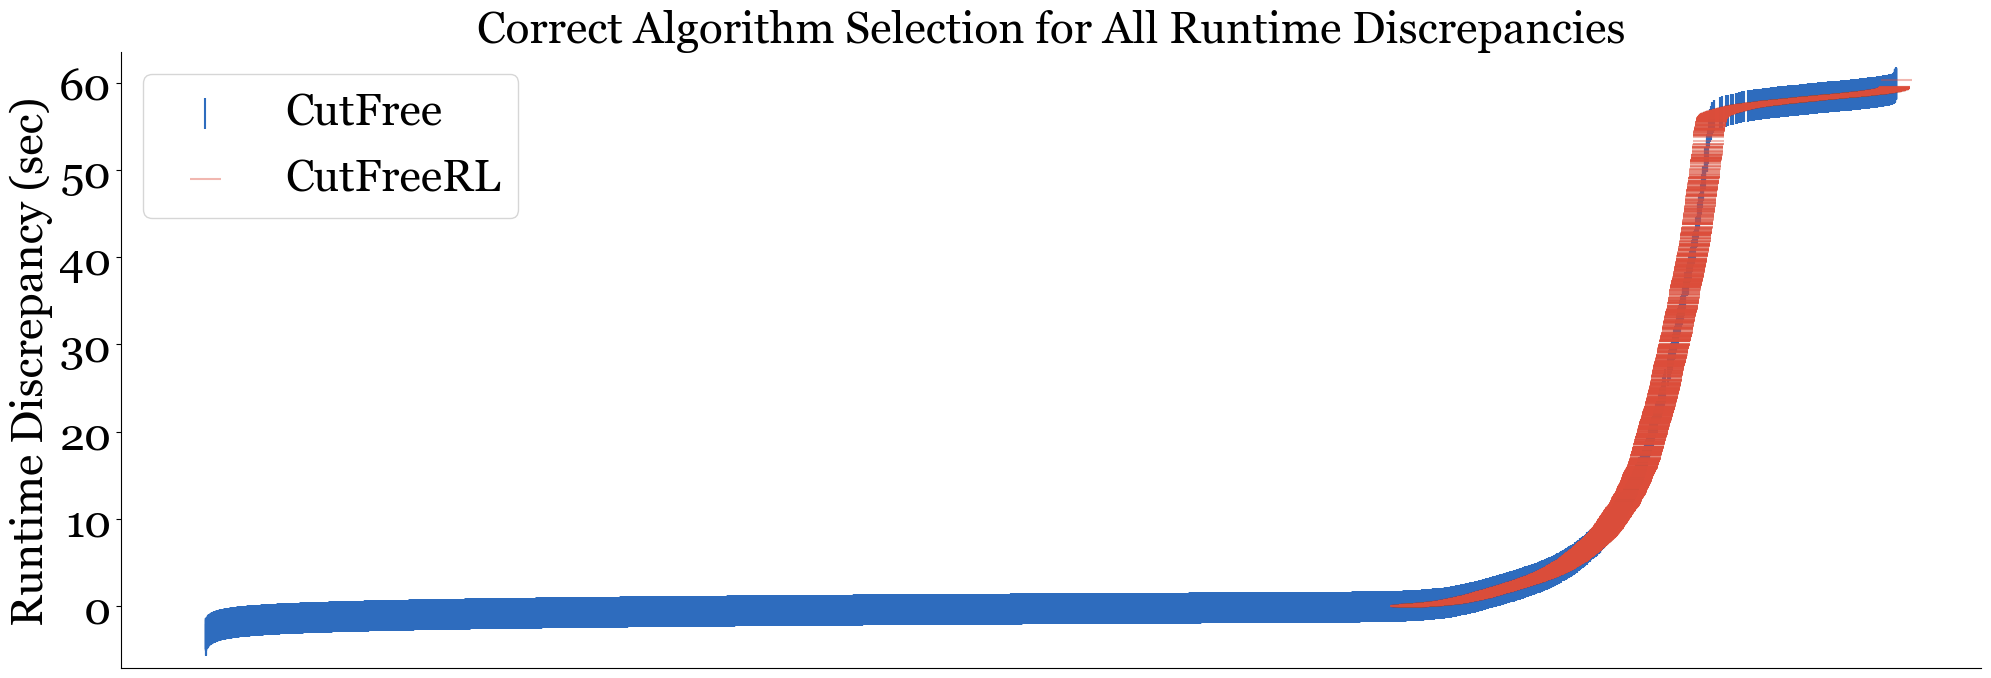

In [9]:
# set colors and font for plots
rgb = []
for _ in df[df["Correct_Algorithm_Choice"] == 0].index:
    c = [46/255, 108/255, 190/255]
    rgb.append(c)

rgb2 = []
for _ in df[df["Correct_Algorithm_Choice"] == 1].index:
    c = [220/255, 77/255, 58/255]
    rgb2.append(c)

gfont = {"fontname": "Georgia"}
font = font_manager.FontProperties(family="Georgia", style="normal", size=32)

def correct_selection(df):
    # sort dataframe by time discrepancy
    df = df.sort_values(by=["Time_Discrepancy"]).reset_index(drop=True)
    
    plt.figure(figsize=(24, 8))

    # plot expected algorithm selection for all time discrepancies
    plt.scatter(
        df[df["Correct_Algorithm_Choice"] == 0].index, 
        df[df["Correct_Algorithm_Choice"] == 0]["Time_Discrepancy"], 
        c=rgb,
        marker="|",
        s=500,
    )
    plt.scatter(
        df[df["Correct_Algorithm_Choice"] == 1].index, 
        df[df["Correct_Algorithm_Choice"] == 1]["Time_Discrepancy"], 
        c=rgb2,
        marker="_",
        s=500,
        alpha=0.4
    )
        
    # set labels
    plt.title(
        "Correct Algorithm Selection for All Runtime Discrepancies", 
        fontsize=32, 
        **gfont
    )
    plt.ylabel(
        "Runtime Discrepancy (sec)", 
        fontsize=32, 
        **gfont
    )
    plt.legend(
        ["CutFree", "CutFreeRL"], 
        prop=font
    )

    # fix axis
    ax = plt.gca()
    plt.xticks(fontsize=32, **gfont)
    plt.yticks(fontsize=32, **gfont)
    ax.get_xaxis().set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    # save figure
    plt.savefig(save_folder + "/results/correct_algorithm_selection.png")

correct_selection(df)

## Set Constants

In [10]:
# bert constants
KFOLDS = 5
EPOCHS = 15
BATCH_SIZE = 64

BERT_MODEL_NAME = "distilbert-base-uncased"
MAX_LENGTH = 64

# mlp constants
MLP_KFOLDS = 5
MLP_EPOCHS = 15
MLP_BATCH_SIZE = 64

# Build, Train, and Evaluate BERT Model

In [11]:
def build_bert():
    # bert input layers
    input_ids = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), 
        name="input_ids", 
        dtype="int32"
    )
    attention_mask = tf.keras.layers.Input(
        shape=(MAX_LENGTH,), 
        name="attention_mask", 
        dtype="int32"
    )

    # bert model
    bert_model = TFDistilBertModel.from_pretrained(
        BERT_MODEL_NAME, 
        output_attentions=False, 
        output_hidden_states=False
    )([input_ids, attention_mask])
    bert_output = bert_model.last_hidden_state[:, 0, :]
    bert_head = tf.keras.layers.Dropout(
        0.8, 
        name="dropout_0_bert"
    )(bert_output)

    # oligo length input layer
    oligo_length_input = tf.keras.layers.Input(
        shape=(1,),
        name="oligo_length_input",
        dtype="float32"
    )

    # concatenate bert and oligo outputs
    concatenate = tf.keras.layers.concatenate(
        [bert_head, oligo_length_input], 
        name="concatenate"
    )

    # mlp for head of bert model
    bert_mlp = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                768, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_1_bert"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_1_bert"),
            tf.keras.layers.Dropout(0.4, name="dropout_1_bert"),
            tf.keras.layers.Activation("relu", name="relu_1_bert"),
            tf.keras.layers.Dense(
                128, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_2_bert"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_2_bert"),
            tf.keras.layers.Dropout(0.4, name="dropout_2_bert"),
            tf.keras.layers.Activation("relu", name="relu_2_bert"),
            tf.keras.layers.Dense(
                64, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_3_bert"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_3_bert"),
            tf.keras.layers.Dropout(0.4, name="dropout_3_bert"),
            tf.keras.layers.Activation("relu", name="relu_3_bert")
        ], 
        name="bert_mlp"
    )(concatenate)

    # output layer
    output = tf.keras.layers.Dense(
        1, 
        activation="sigmoid", 
        name="output"
    )(bert_mlp)

    # combine input and output layers to create model
    model = tf.keras.Model(
        inputs=[input_ids, attention_mask, oligo_length_input], 
        outputs=output, 
        name="BERT_AlgorithmClassifier"
    )

    return model

model = build_bert()
model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "BERT_AlgorithmClassifier"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 64)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 64)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_ids[0][0]',              
 BertModel)                     ast_hidden_state=(N               'attention_mask[0][0]']         
                                one, 64, 768),                                                    
                                 hidden_states=None                        

## Helper Functions for Model Evaluation

In [12]:
def plot_train_val(history, k):
    fig = plt.figure(figsize=(16, 12))

    # create accuracy plot
    plt.subplot(2, 1, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # create loss plot
    plt.subplot(2, 1, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

    # save figure
    fig.savefig(save_folder + "/results/k" + str(k) + "_training.png")

In [13]:
def evaluate_model(
    tokenizer, 
    model, 
    bert_test_dataset, 
    texts_test, 
    x_test_oligos, 
    x_test_sites,
    k
):
    # retrieve model predictions on test data
    y_pred = model.predict(texts_test)
    y_pred = np.round(y_pred)
    
    # make pred and test labels floats
    y_pred_float = np.array(y_pred, dtype=np.float32).reshape(-1, 1)
    y_test_float = np.array(y_test, dtype=np.float32).reshape(-1, 1)

    # get loss and accuracy from y_pred
    loss = tf.keras.losses.binary_crossentropy(y_pred_float, y_test_float)
    loss - tf.reduce_mean(loss) * 100
    acc = tf.keras.metrics.binary_accuracy(y_pred_float, y_test_float)
    acc = tf.reduce_mean(acc) * 100

    # save loss and accuracy
    with open(
        save_folder + "/results/k" + str(k) + "_loss_results.csv", "w"
    ) as f:
        writer = csv.writer(f)
        writer.writerow([loss])
    with open(
        save_folder + "/results/k" + str(k) + "_accuracy_results.csv", "w"
    ) as f:
        writer = csv.writer(f)
        writer.writerow([acc])
        
    # create classification report
    class_report = classification_report(
        y_pred_float, 
        y_test_float, 
        target_names=["CutFree", "CutFreeRL"]
    )

    # save classification report
    with open(
        save_folder + "/results/k" + str(k) + "_classification_report.csv", "w"
    ) as f:
        writer = csv.writer(f)
        writer.writerow([class_report])

    # create confusion matrix
    cm = confusion_matrix(y_pred_float, y_test_float)
    fig = ConfusionMatrixDisplay(cm, display_labels=["CutFree", "CutFreeRL"])
    fig.plot()

    # save confusion matrix
    plt.savefig(save_folder + "/results/k" + str(k) + "_confusion_matrix.png")

    # copy dataframe
    df_test = df.copy()

    # initialize prediction column
    df_test["Correct_Prediction"] = np.nan

    # update prediction column for test data
    df_test.loc[df_test.index.isin(y_test.index), "Correct_Prediction"] = \
        y_pred_float == y_test_float

    # drop unassigned rows
    df_test = df_test.dropna(subset=["Correct_Prediction"])

    # sort dataframe by discrepancy and reset index
    df_test = df_test.sort_values(
        by=["Time_Discrepancy"], 
        ascending=True
    ).reset_index(drop=True)

    fig, ax = plt.subplots(figsize=(24, 16))

    # plot correct and incorrect selections for all time discrepancies
    plt.subplot(2, 1, 1)
    correct_conditions = df_test["Correct_Prediction"]
    plt.scatter(
        df_test[correct_conditions].index,
        df_test.loc[correct_conditions, "Time_Discrepancy"], 
        c="g",
        linewidths=1,
        marker="s",
        s=50
    )
    incorrect_conditions = df_test["Correct_Prediction"] == False
    plt.scatter(
        df_test[incorrect_conditions].index,
        df_test.loc[incorrect_conditions, "Time_Discrepancy"], 
        c="r",
        linewidths=1,
        marker="x",
        s=500
    )

    # set labels
    plt.title(
        f"Accuracy of BERT-based Model ({acc:.1f}%) for"
        + " All Runtime Discrepancies", 
        fontsize=32, 
        **gfont
    )
    plt.ylabel("Runtime Discrepancy (sec)", fontsize=32, **gfont)
    plt.legend(
        [f"Correct Predictions ({len(df_test[correct_conditions])})", 
        f"Incorrect Predictions ({len(df_test[incorrect_conditions])})"], 
        prop=font
    )

    # fix axis
    ax = plt.gca()
    plt.xticks(fontsize=32, **gfont)
    plt.yticks(fontsize=32, **gfont)
    ax.get_xaxis().set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    # plot problematic and nonproblematic selections for all time discrepancies
    plt.subplot(2, 1, 2)

    nonproblematic_conditions = (
        (df_test["Correct_Prediction"]) \
            | ((df_test["Correct_Prediction"] == False) \
            & (df_test["Correct_Algorithm_Choice"] == 0)) \
            | ((df_test["Correct_Prediction"] == False) \
            & (df_test["CutFree_Time"] <= 60))
    )
    plt.scatter(
        df_test[nonproblematic_conditions].index,
        df_test.loc[nonproblematic_conditions, "Time_Discrepancy"], 
        c="g",
        linewidths=1,
        marker="s",
        s=50
    )

    # problematic conditions are defined as incorrect predictions that place 
    # the system at risk of runtime explosion
    problematic_conditions = (
        (df_test["Correct_Prediction"] == False) \
            & (df_test["Correct_Algorithm_Choice"] == 1) \
            & (df_test["CutFree_Time"] >= 60)
    )
    plt.scatter(
        df_test[problematic_conditions].index,
        df_test.loc[problematic_conditions, "Time_Discrepancy"], 
        c="r",
        linewidths=1,
        marker="x",
        s=500
    )

    # set labels
    plt.title(
        f"Unproblematic vs. Problematic Predictions for All Runtime"
        + " Discrepancies", 
        fontsize=32, 
        **gfont
    )
    plt.ylabel(
        "Runtime Discrepancy (sec)", 
        fontsize=32, 
        **gfont
    )
    plt.legend(
        [
            "Unproblematic Predictions " \
                + f"({len(df_test[nonproblematic_conditions])})", 
            "Problematic Predictions " \
                + f"({len(df_test[problematic_conditions])})"
        ], 
        prop=font
    )

    # fix axis
    ax = plt.gca()
    plt.xticks(fontsize=32, **gfont)
    plt.yticks(fontsize=32, **gfont)
    ax.get_xaxis().set_visible(False)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    # save figure
    plt.savefig(
        save_folder + "/results/k" + str(k) + "_runtime_discrepancies.png"
    )

    # get sensitivity for values above runtime limit
    sensitivity = (
        len(df_test[nonproblematic_conditions])) \
            / (len(df_test[nonproblematic_conditions]) \
            + len(df_test[problematic_conditions])
    ) * 100

    # save sensitivity
    with open(
        save_folder + "/results/k" + str(k) + "_sensitivity_results.csv", "w"
    ) as f:
        writer = csv.writer(f)
        writer.writerow([sensitivity])

## Train Model via K-Fold Cross Validation

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/15
274/274 [==============================] - 85s 277ms/step - loss: 22.4791 - accuracy: 0.5735 - val_loss: 20.0338 - val_accuracy: 0.7867
Epoch 2/15
274/274 [==============================] - 72s 264ms/step - loss: 18.2885 - accuracy: 0.7194 - val_loss: 16.1886 - val_accuracy: 0.8551
Epoch 3/15
274/274 [==============================] - 71s 257ms/step - loss: 14.6515 - accuracy: 0.7826 - val_loss: 12.9434 - val_accuracy: 0.8352
Epoch 4/15
274/274 [==============================] - 72s 261ms/step - loss: 11.5686 - accuracy: 0.8178 - val_loss: 10.1027 - val_accuracy: 0.8724
Epoch 5/15
274/274 [==============================] - 72s 261ms/step - loss: 9.0796 - accuracy: 0.8352 - val_loss: 7.8771 - val_accuracy: 0.8891
Epoch 6/15
274/274 [==============================] - 71s 257ms/step - loss: 7.1345 - accuracy: 0.8568 - val_loss: 6.2814 - val_accuracy: 0.8752
Epoch 7/15
274/274 [==============================] - 71s 257ms/step - loss: 5.7067 - accuracy: 0.8657 - val_loss: 5.0986 

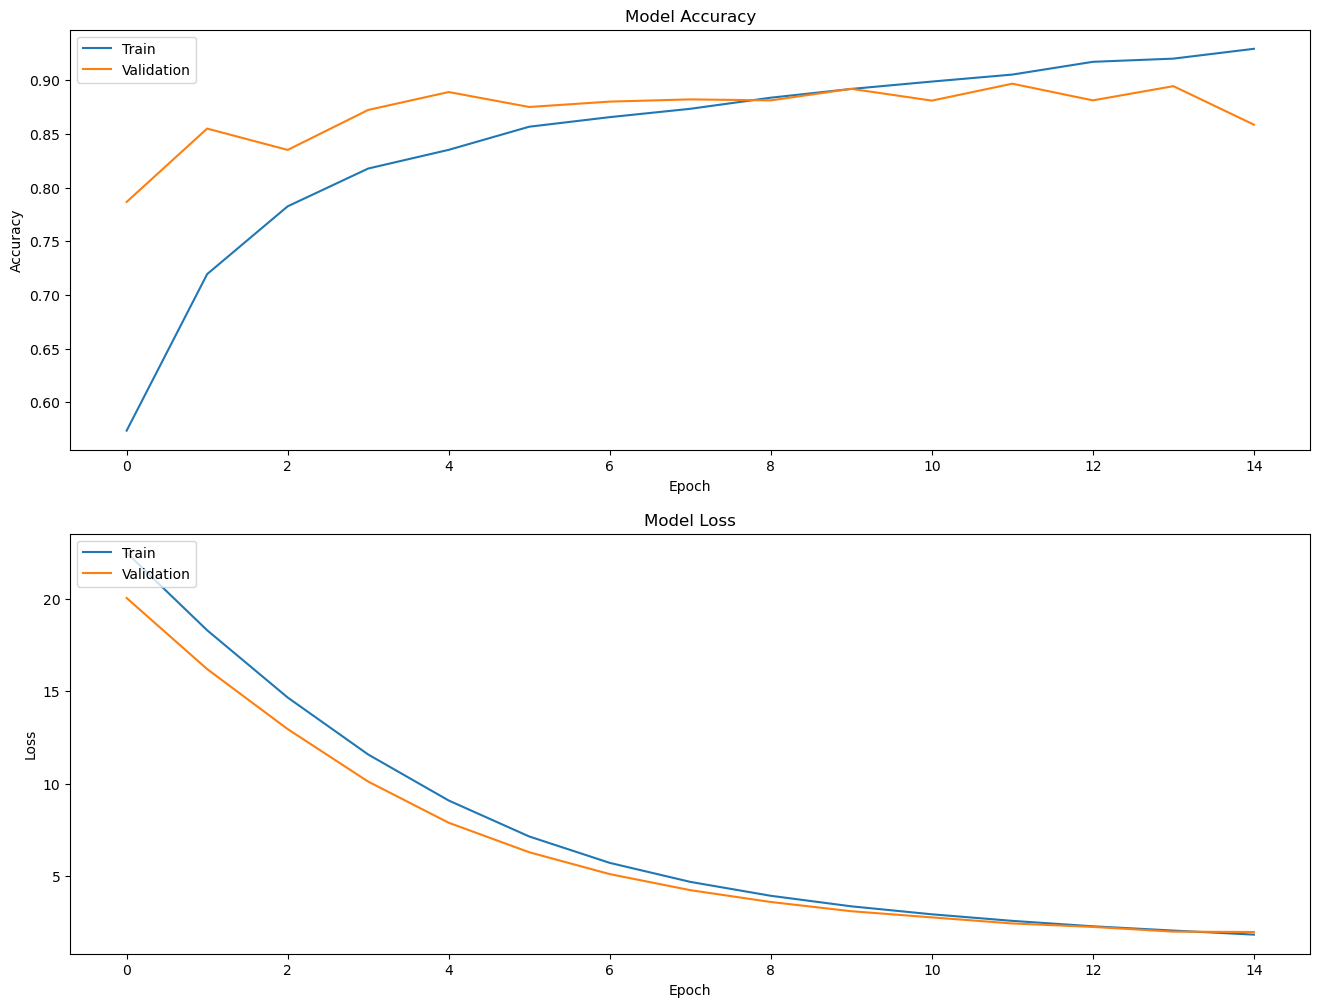

171/171 [==============================] - 9s 45ms/step


C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test.index.isin(y_test.index), "Correct_Prediction"] = \
C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:80: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. in

Epoch 1/15
274/274 [==============================] - 82s 266ms/step - loss: 22.7136 - accuracy: 0.6383 - val_loss: 20.4077 - val_accuracy: 0.8144
Epoch 2/15
274/274 [==============================] - 71s 257ms/step - loss: 18.7491 - accuracy: 0.7534 - val_loss: 16.7809 - val_accuracy: 0.7775
Epoch 3/15
274/274 [==============================] - 72s 261ms/step - loss: 15.1595 - accuracy: 0.7995 - val_loss: 13.3227 - val_accuracy: 0.8612
Epoch 4/15
274/274 [==============================] - 72s 261ms/step - loss: 12.0182 - accuracy: 0.8278 - val_loss: 10.5087 - val_accuracy: 0.8656
Epoch 5/15
274/274 [==============================] - 72s 262ms/step - loss: 9.4299 - accuracy: 0.8466 - val_loss: 8.2328 - val_accuracy: 0.8704
Epoch 6/15
274/274 [==============================] - 72s 262ms/step - loss: 7.4028 - accuracy: 0.8601 - val_loss: 6.4882 - val_accuracy: 0.8754
Epoch 7/15
274/274 [==============================] - 72s 261ms/step - loss: 5.8924 - accuracy: 0.8686 - val_loss: 5.2194 

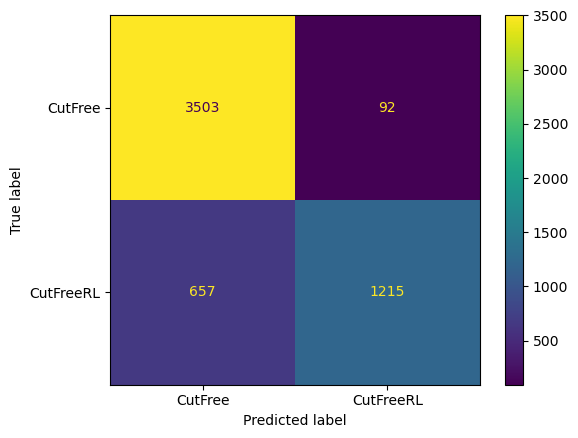

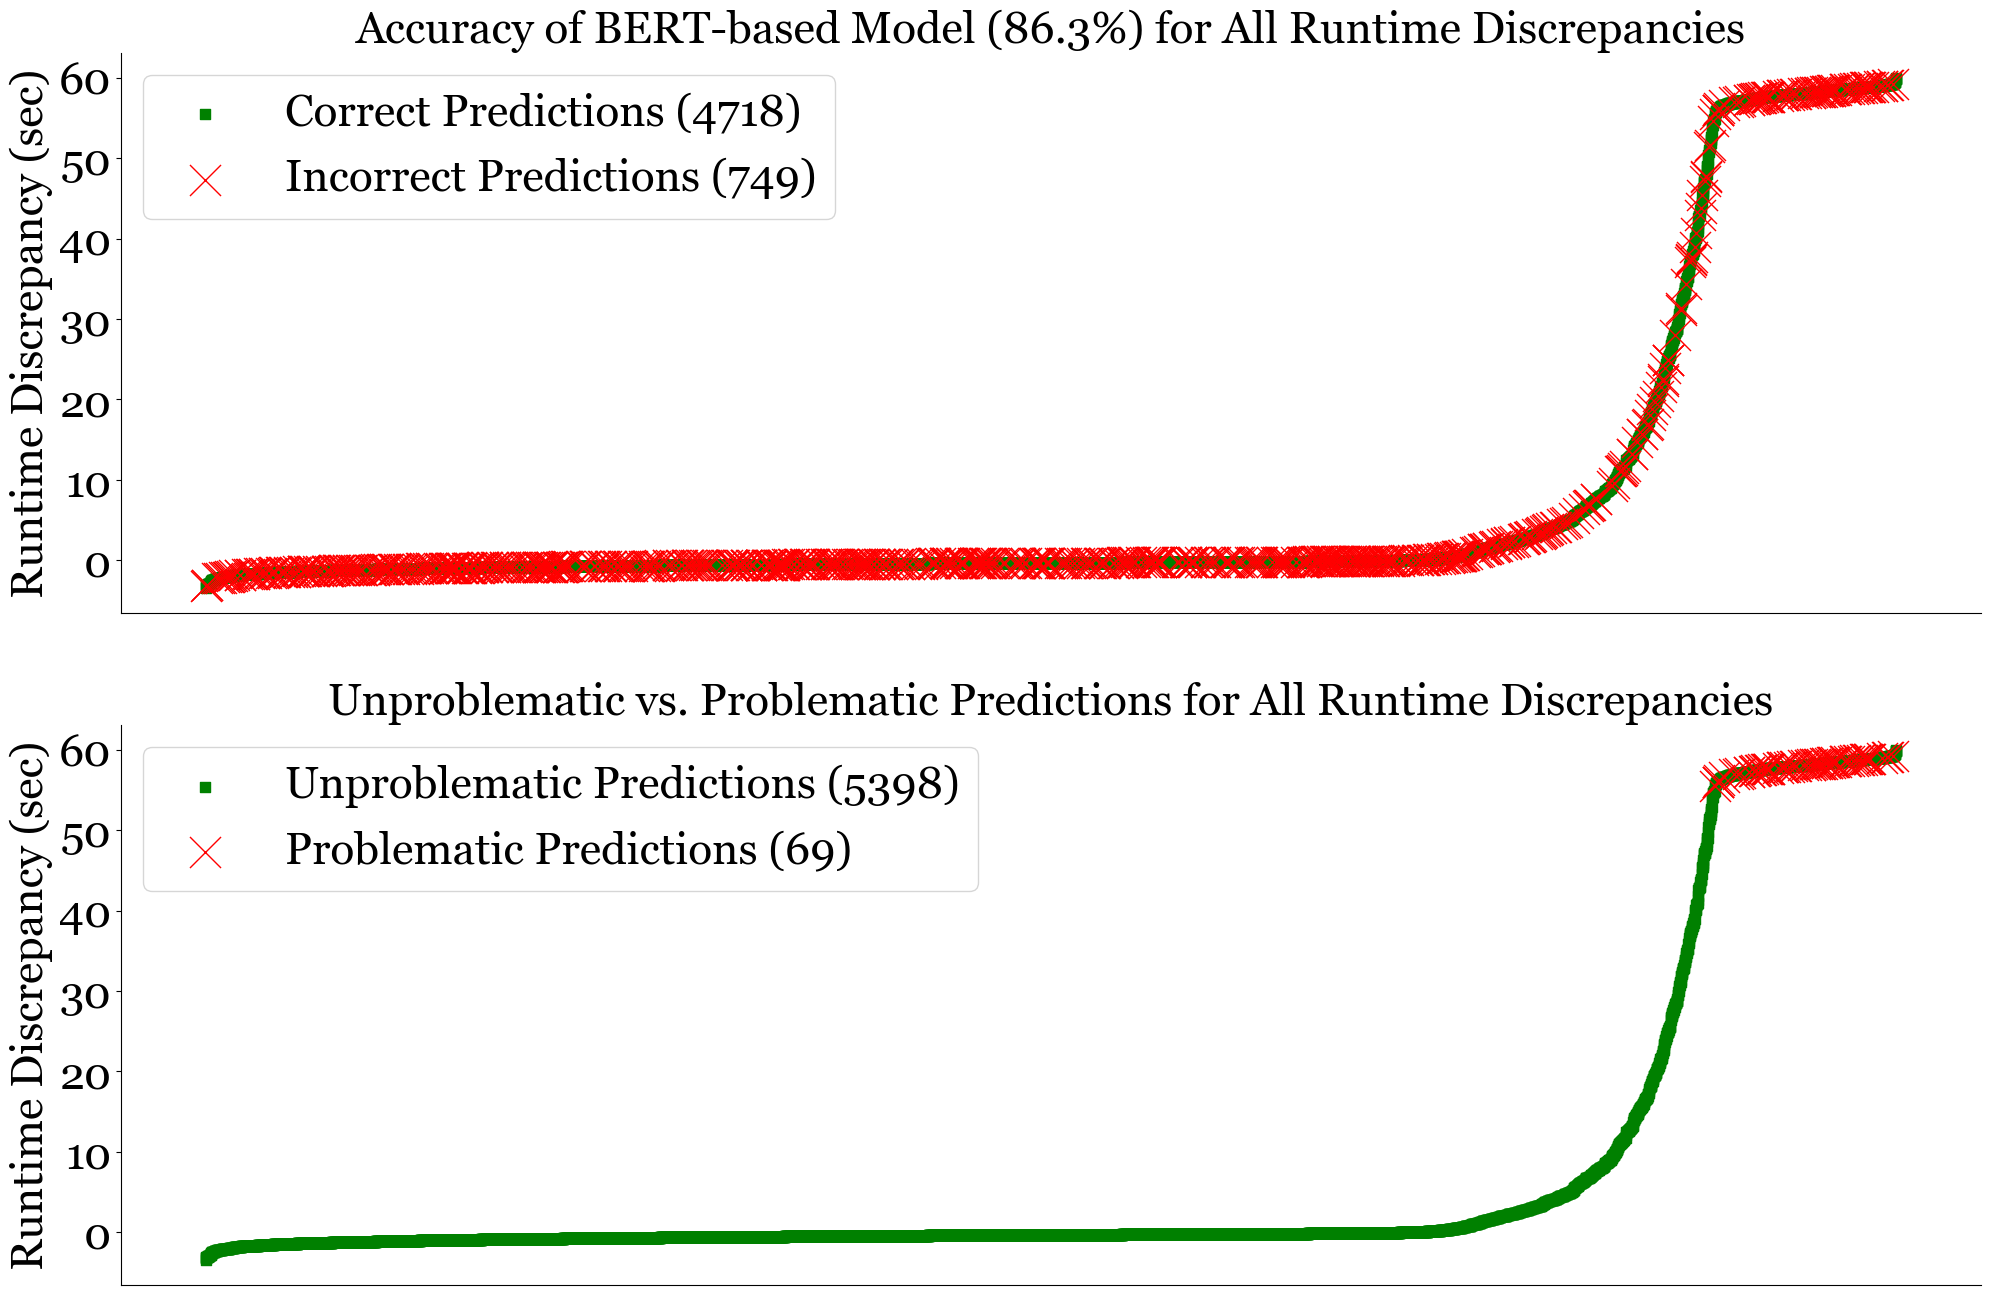

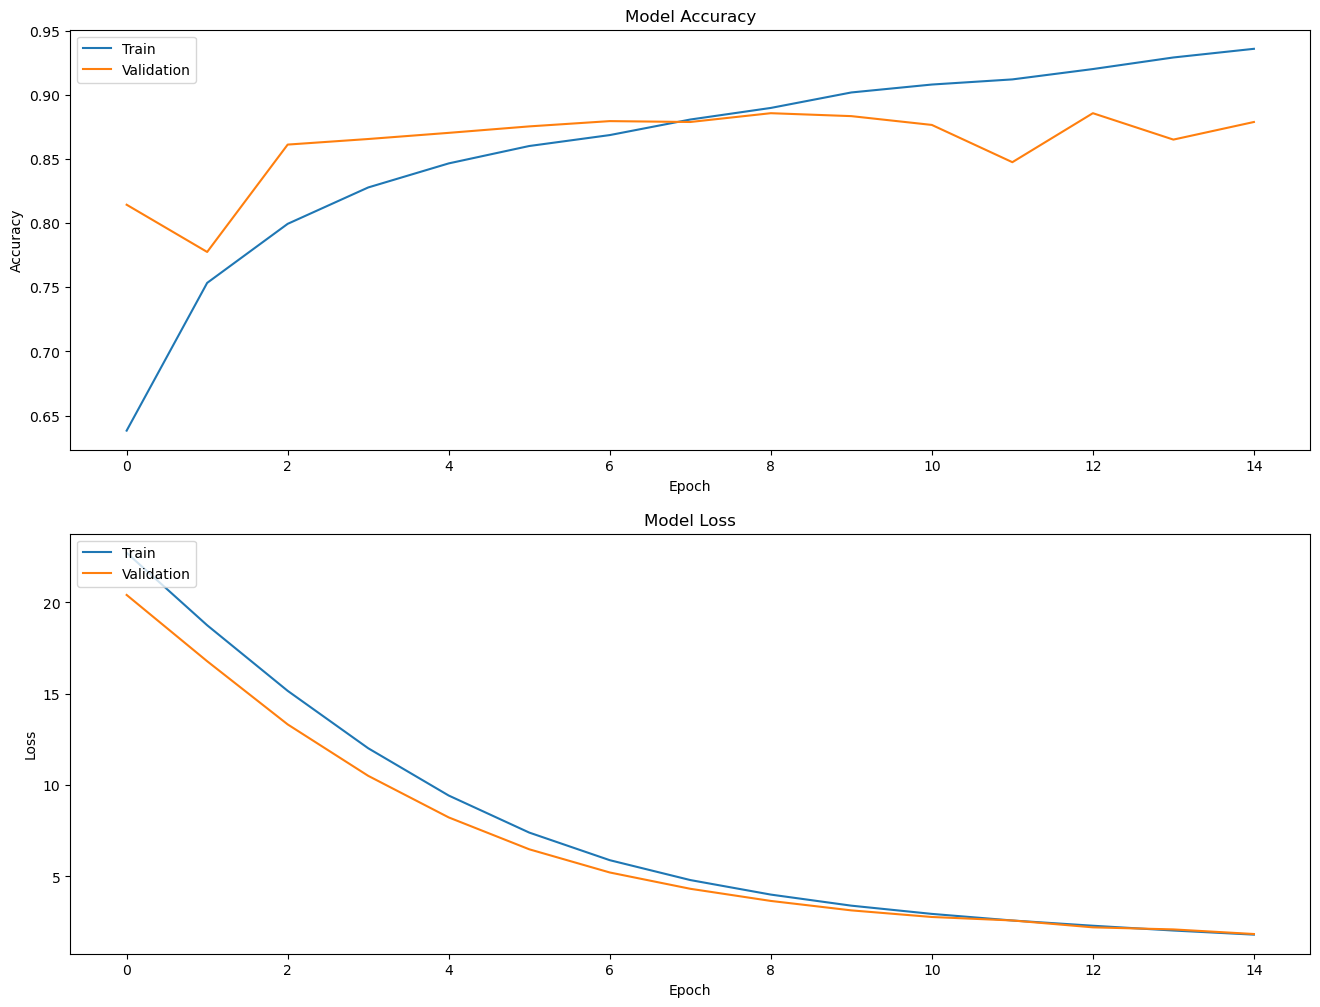

171/171 [==============================] - 9s 46ms/step


C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test.index.isin(y_test.index), "Correct_Prediction"] = \
C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:80: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. in

Epoch 1/15
274/274 [==============================] - 87s 282ms/step - loss: 22.6396 - accuracy: 0.6023 - val_loss: 20.3973 - val_accuracy: 0.7752
Epoch 2/15
274/274 [==============================] - 74s 270ms/step - loss: 18.5922 - accuracy: 0.7403 - val_loss: 16.5936 - val_accuracy: 0.8207
Epoch 3/15
274/274 [==============================] - 74s 270ms/step - loss: 14.9782 - accuracy: 0.8004 - val_loss: 13.1644 - val_accuracy: 0.8804
Epoch 4/15
274/274 [==============================] - 73s 266ms/step - loss: 11.8915 - accuracy: 0.8306 - val_loss: 10.3938 - val_accuracy: 0.8742
Epoch 5/15
274/274 [==============================] - 73s 266ms/step - loss: 9.3552 - accuracy: 0.8480 - val_loss: 8.1791 - val_accuracy: 0.8804
Epoch 6/15
274/274 [==============================] - 73s 266ms/step - loss: 7.3834 - accuracy: 0.8609 - val_loss: 6.5719 - val_accuracy: 0.8662
Epoch 7/15
274/274 [==============================] - 75s 272ms/step - loss: 5.9081 - accuracy: 0.8740 - val_loss: 5.2691 

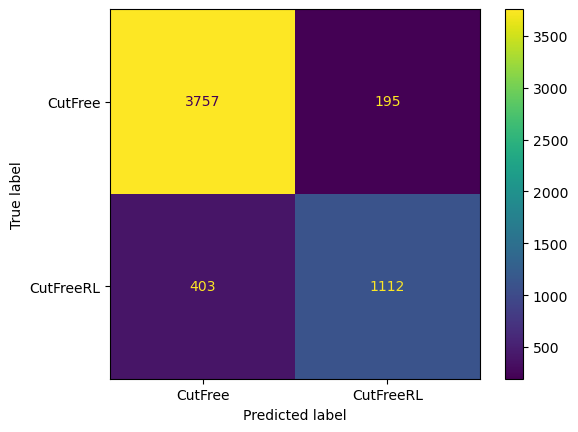

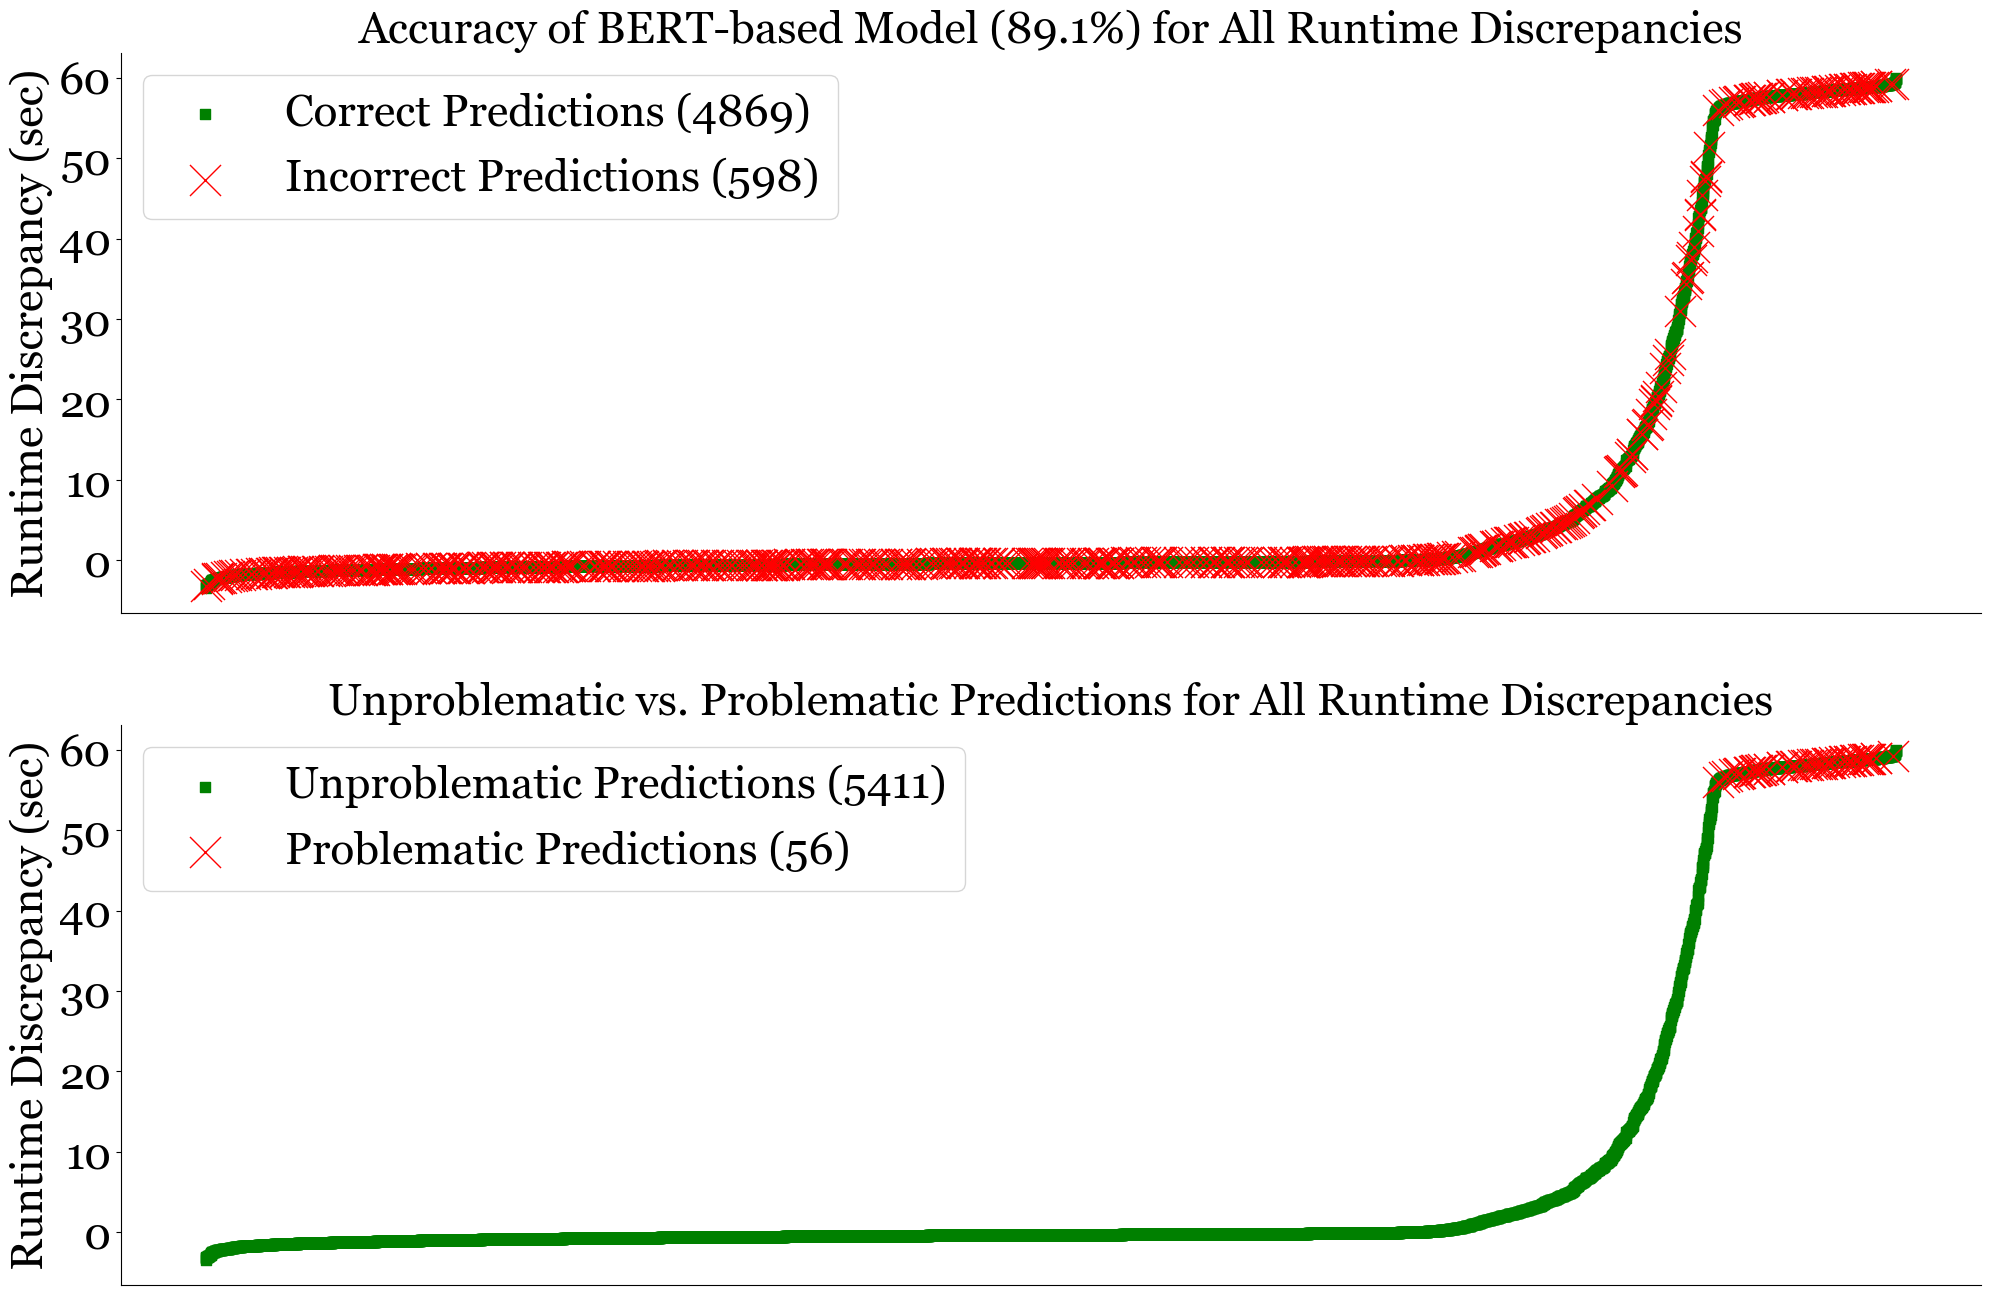

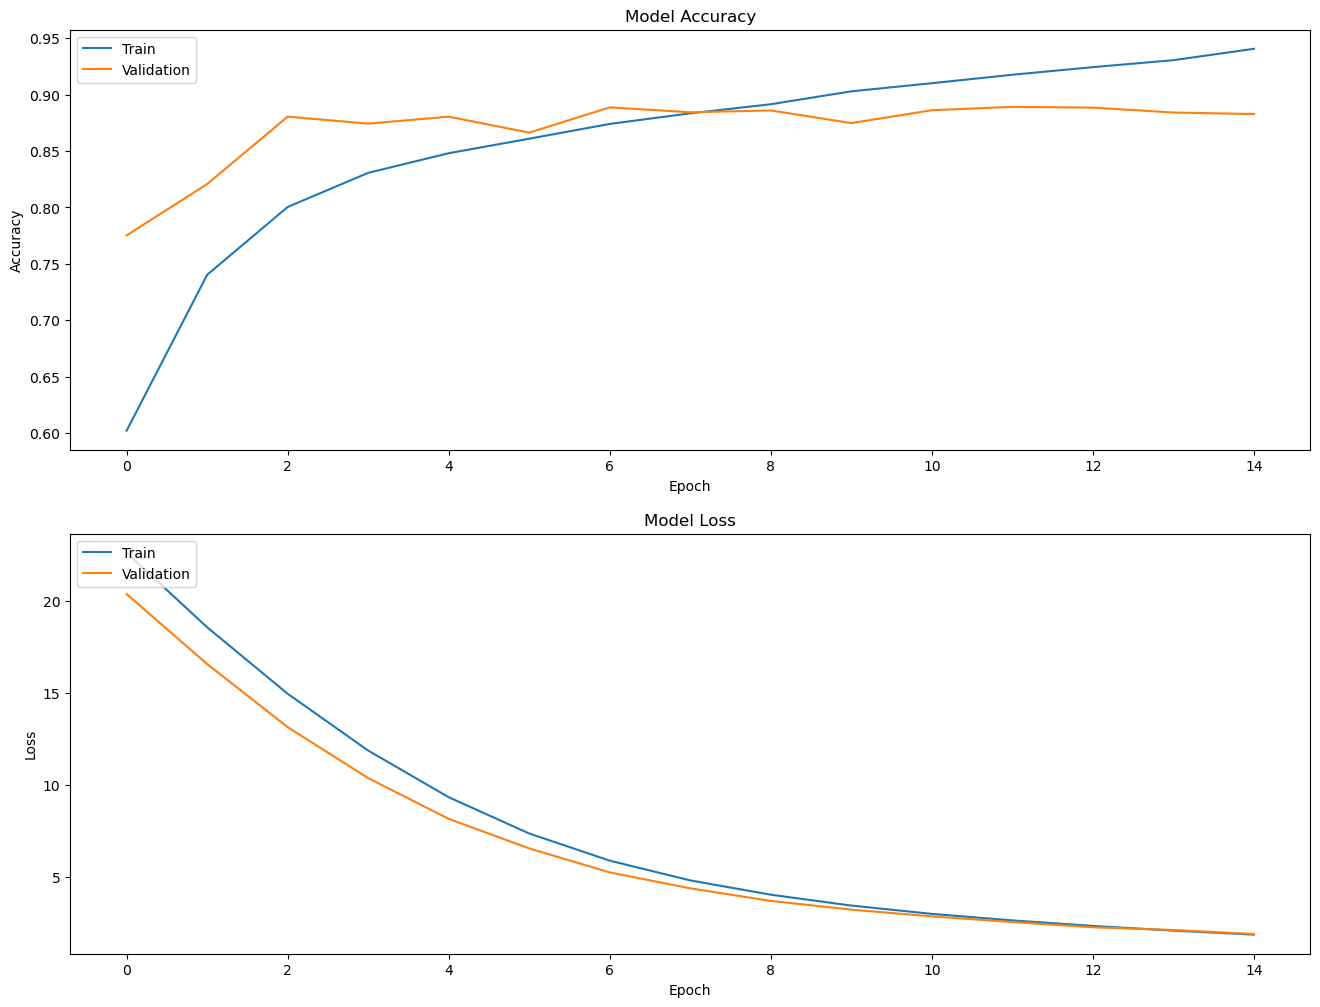

171/171 [==============================] - 9s 46ms/step


C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test.index.isin(y_test.index), "Correct_Prediction"] = \
C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:80: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. in

Epoch 1/15
274/274 [==============================] - 86s 278ms/step - loss: 22.6562 - accuracy: 0.5569 - val_loss: 20.4777 - val_accuracy: 0.5927
Epoch 2/15
274/274 [==============================] - 74s 270ms/step - loss: 18.5334 - accuracy: 0.7113 - val_loss: 16.5352 - val_accuracy: 0.7553
Epoch 3/15
274/274 [==============================] - 74s 270ms/step - loss: 14.8551 - accuracy: 0.7807 - val_loss: 13.0683 - val_accuracy: 0.8601
Epoch 4/15
274/274 [==============================] - 74s 271ms/step - loss: 11.7177 - accuracy: 0.8199 - val_loss: 10.2062 - val_accuracy: 0.8815
Epoch 5/15
274/274 [==============================] - 74s 271ms/step - loss: 9.1707 - accuracy: 0.8477 - val_loss: 7.9452 - val_accuracy: 0.8907
Epoch 6/15
274/274 [==============================] - 78s 283ms/step - loss: 7.2051 - accuracy: 0.8555 - val_loss: 6.3287 - val_accuracy: 0.8779
Epoch 7/15
274/274 [==============================] - 74s 271ms/step - loss: 5.7536 - accuracy: 0.8679 - val_loss: 5.1027 

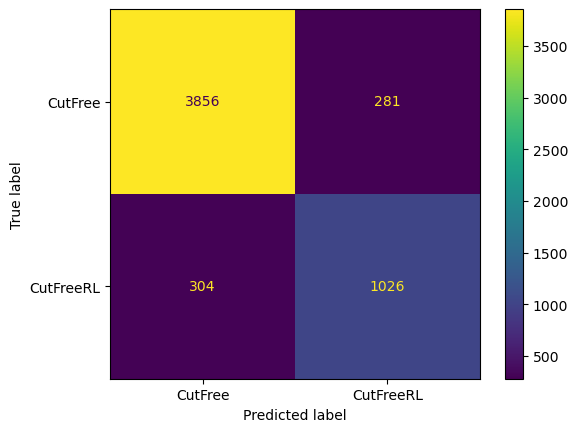

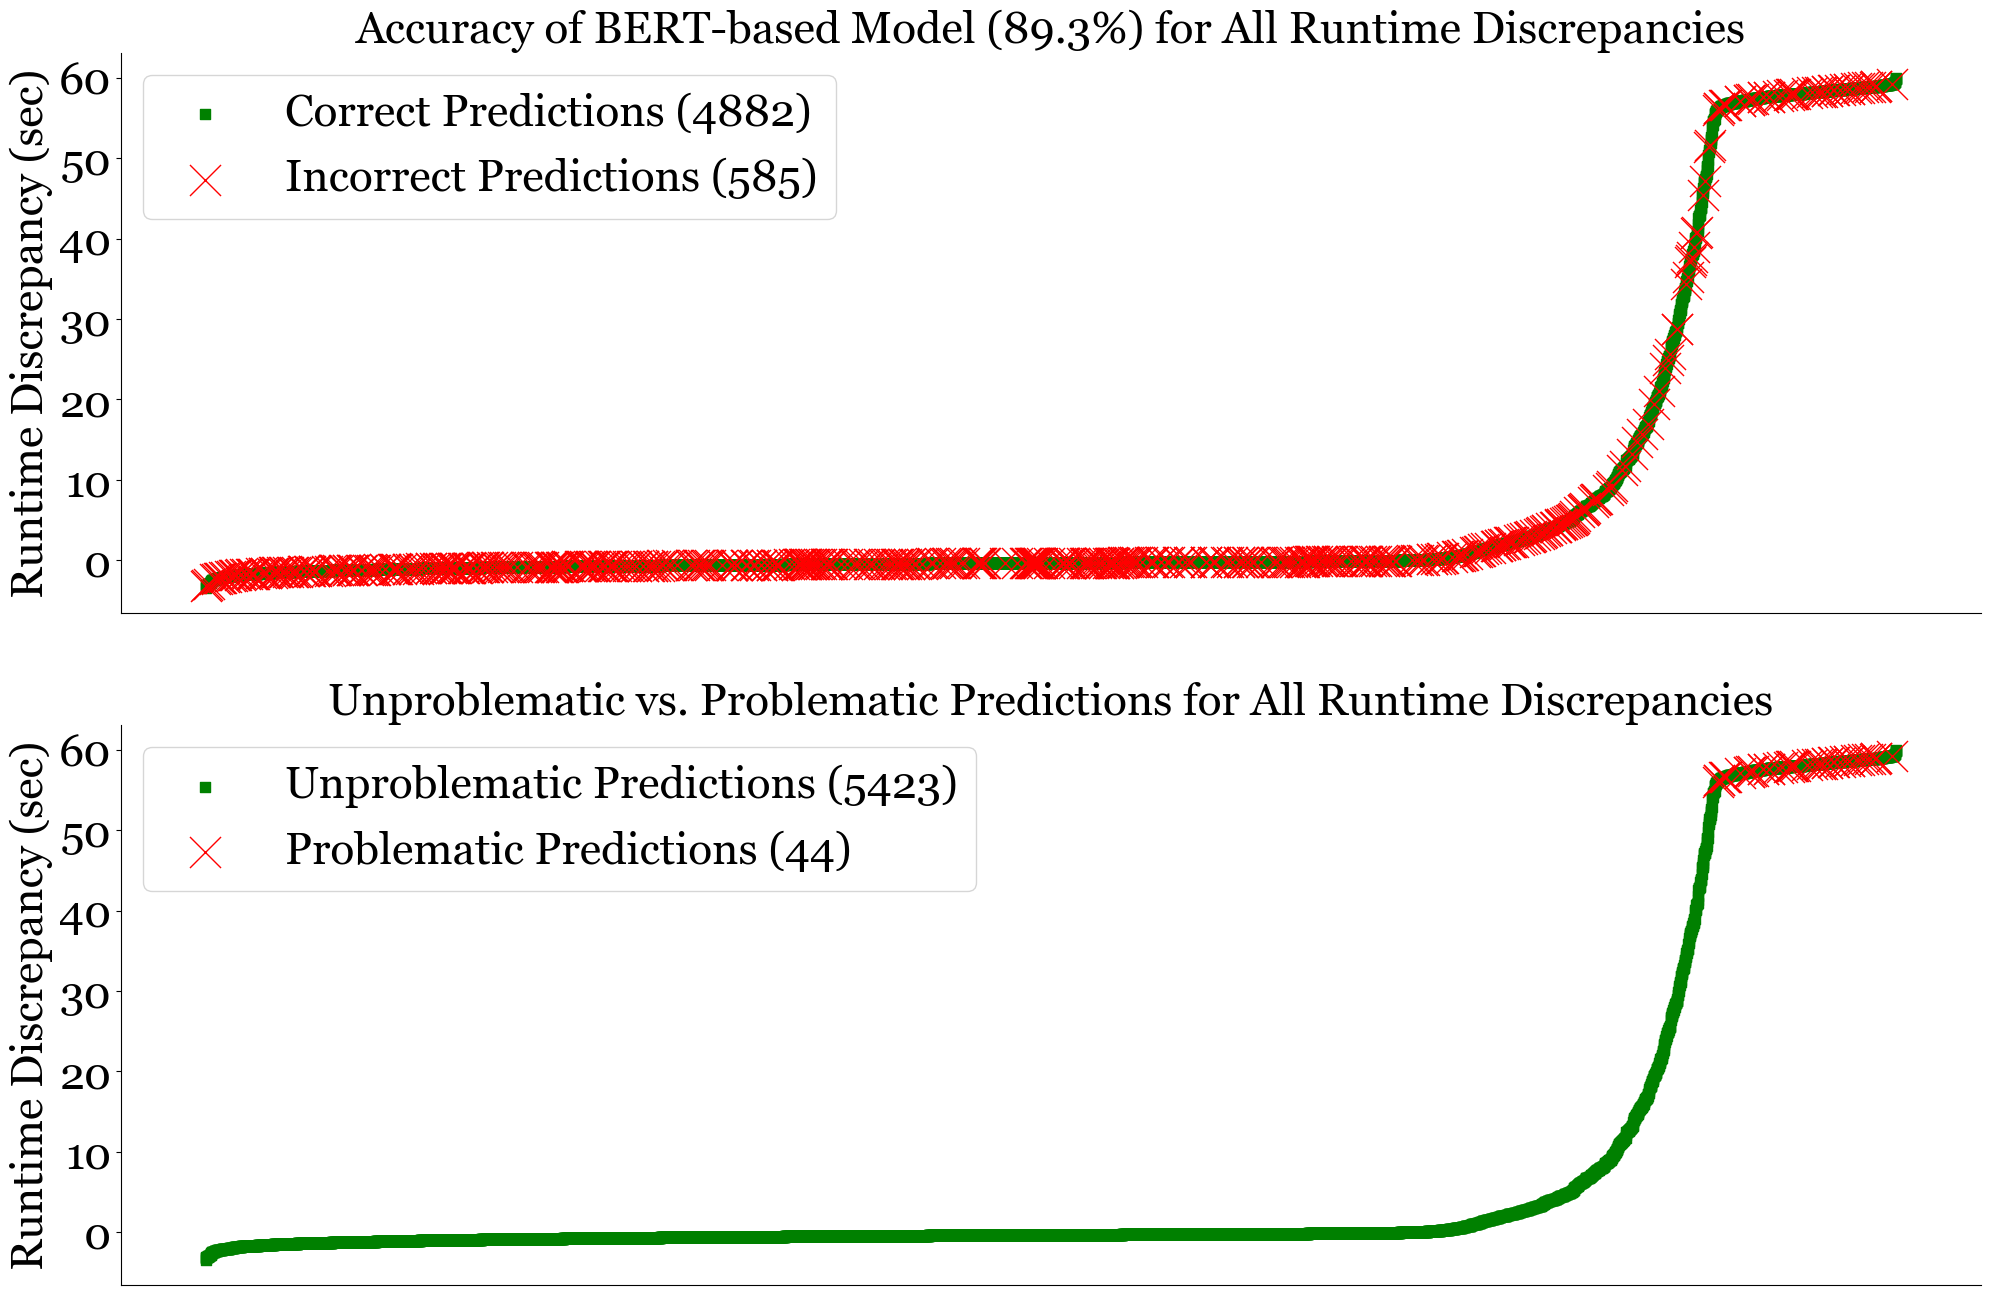

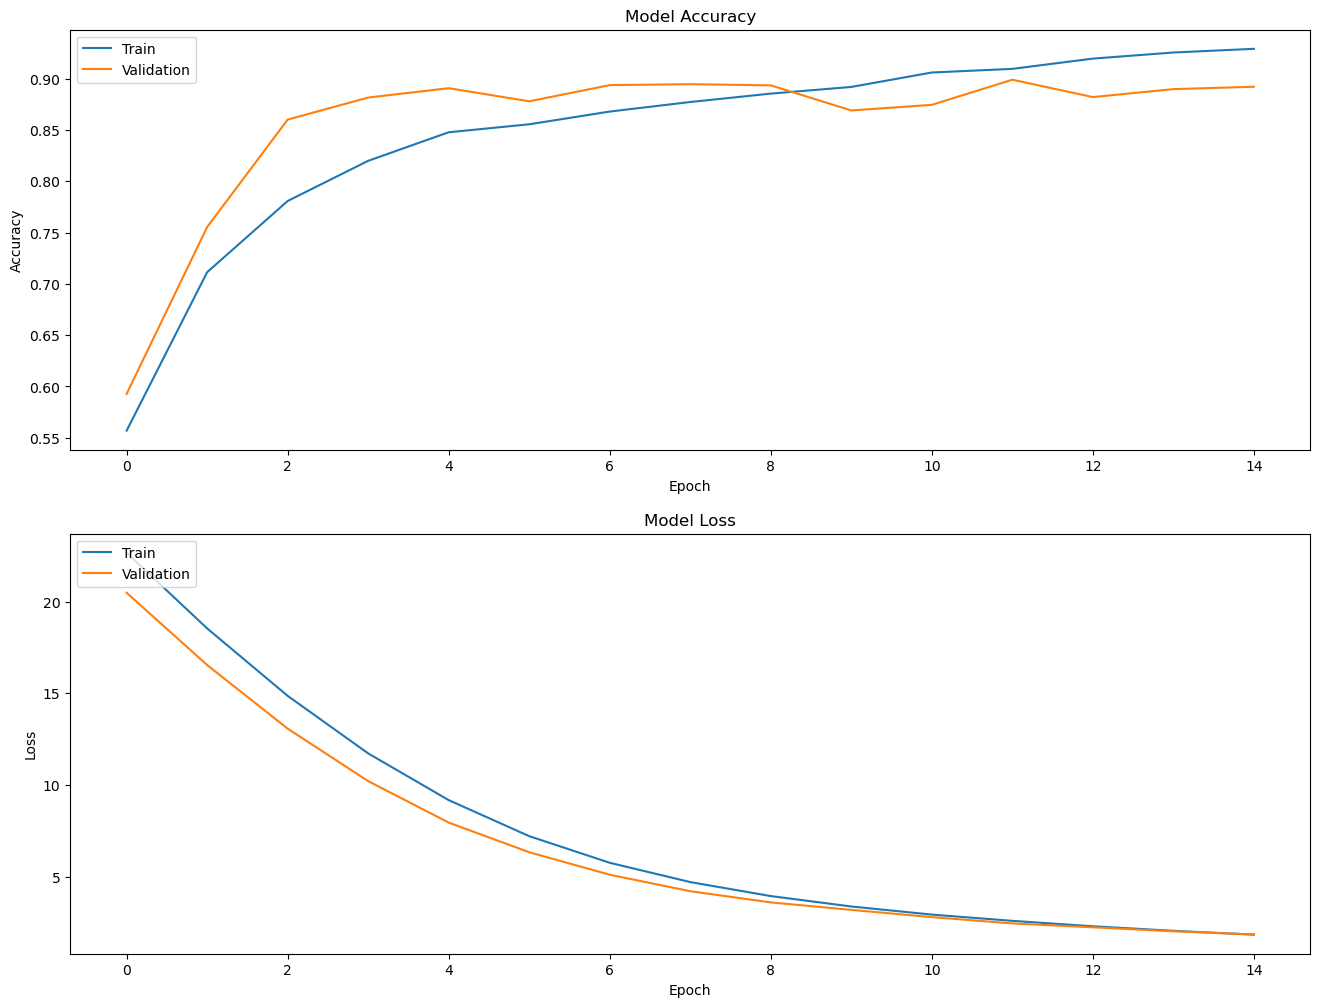

171/171 [==============================] - 9s 44ms/step


C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test.index.isin(y_test.index), "Correct_Prediction"] = \
C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:80: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_layer_norm', 'activation_13', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. in

Epoch 1/15
274/274 [==============================] - 82s 266ms/step - loss: 22.9381 - accuracy: 0.6119 - val_loss: 20.7625 - val_accuracy: 0.8049
Epoch 2/15
274/274 [==============================] - 71s 257ms/step - loss: 19.2126 - accuracy: 0.7392 - val_loss: 17.3085 - val_accuracy: 0.7949
Epoch 3/15
274/274 [==============================] - 72s 261ms/step - loss: 15.7354 - accuracy: 0.7983 - val_loss: 14.0288 - val_accuracy: 0.8134
Epoch 4/15
274/274 [==============================] - 72s 261ms/step - loss: 12.6446 - accuracy: 0.8287 - val_loss: 11.0761 - val_accuracy: 0.8710
Epoch 5/15
274/274 [==============================] - 70s 257ms/step - loss: 10.0366 - accuracy: 0.8434 - val_loss: 8.7817 - val_accuracy: 0.8603
Epoch 6/15
274/274 [==============================] - 70s 257ms/step - loss: 7.9325 - accuracy: 0.8560 - val_loss: 6.9980 - val_accuracy: 0.8486
Epoch 7/15
274/274 [==============================] - 71s 261ms/step - loss: 6.3194 - accuracy: 0.8666 - val_loss: 5.5852

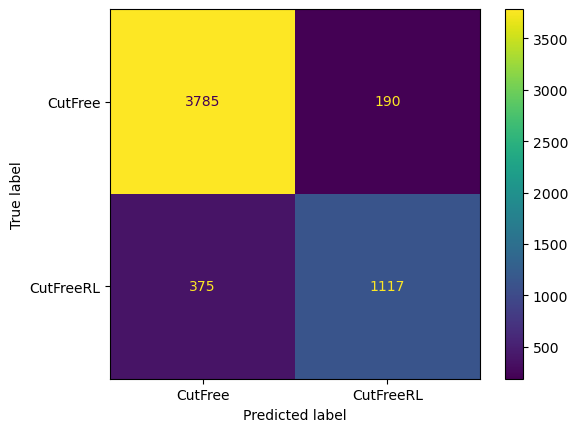

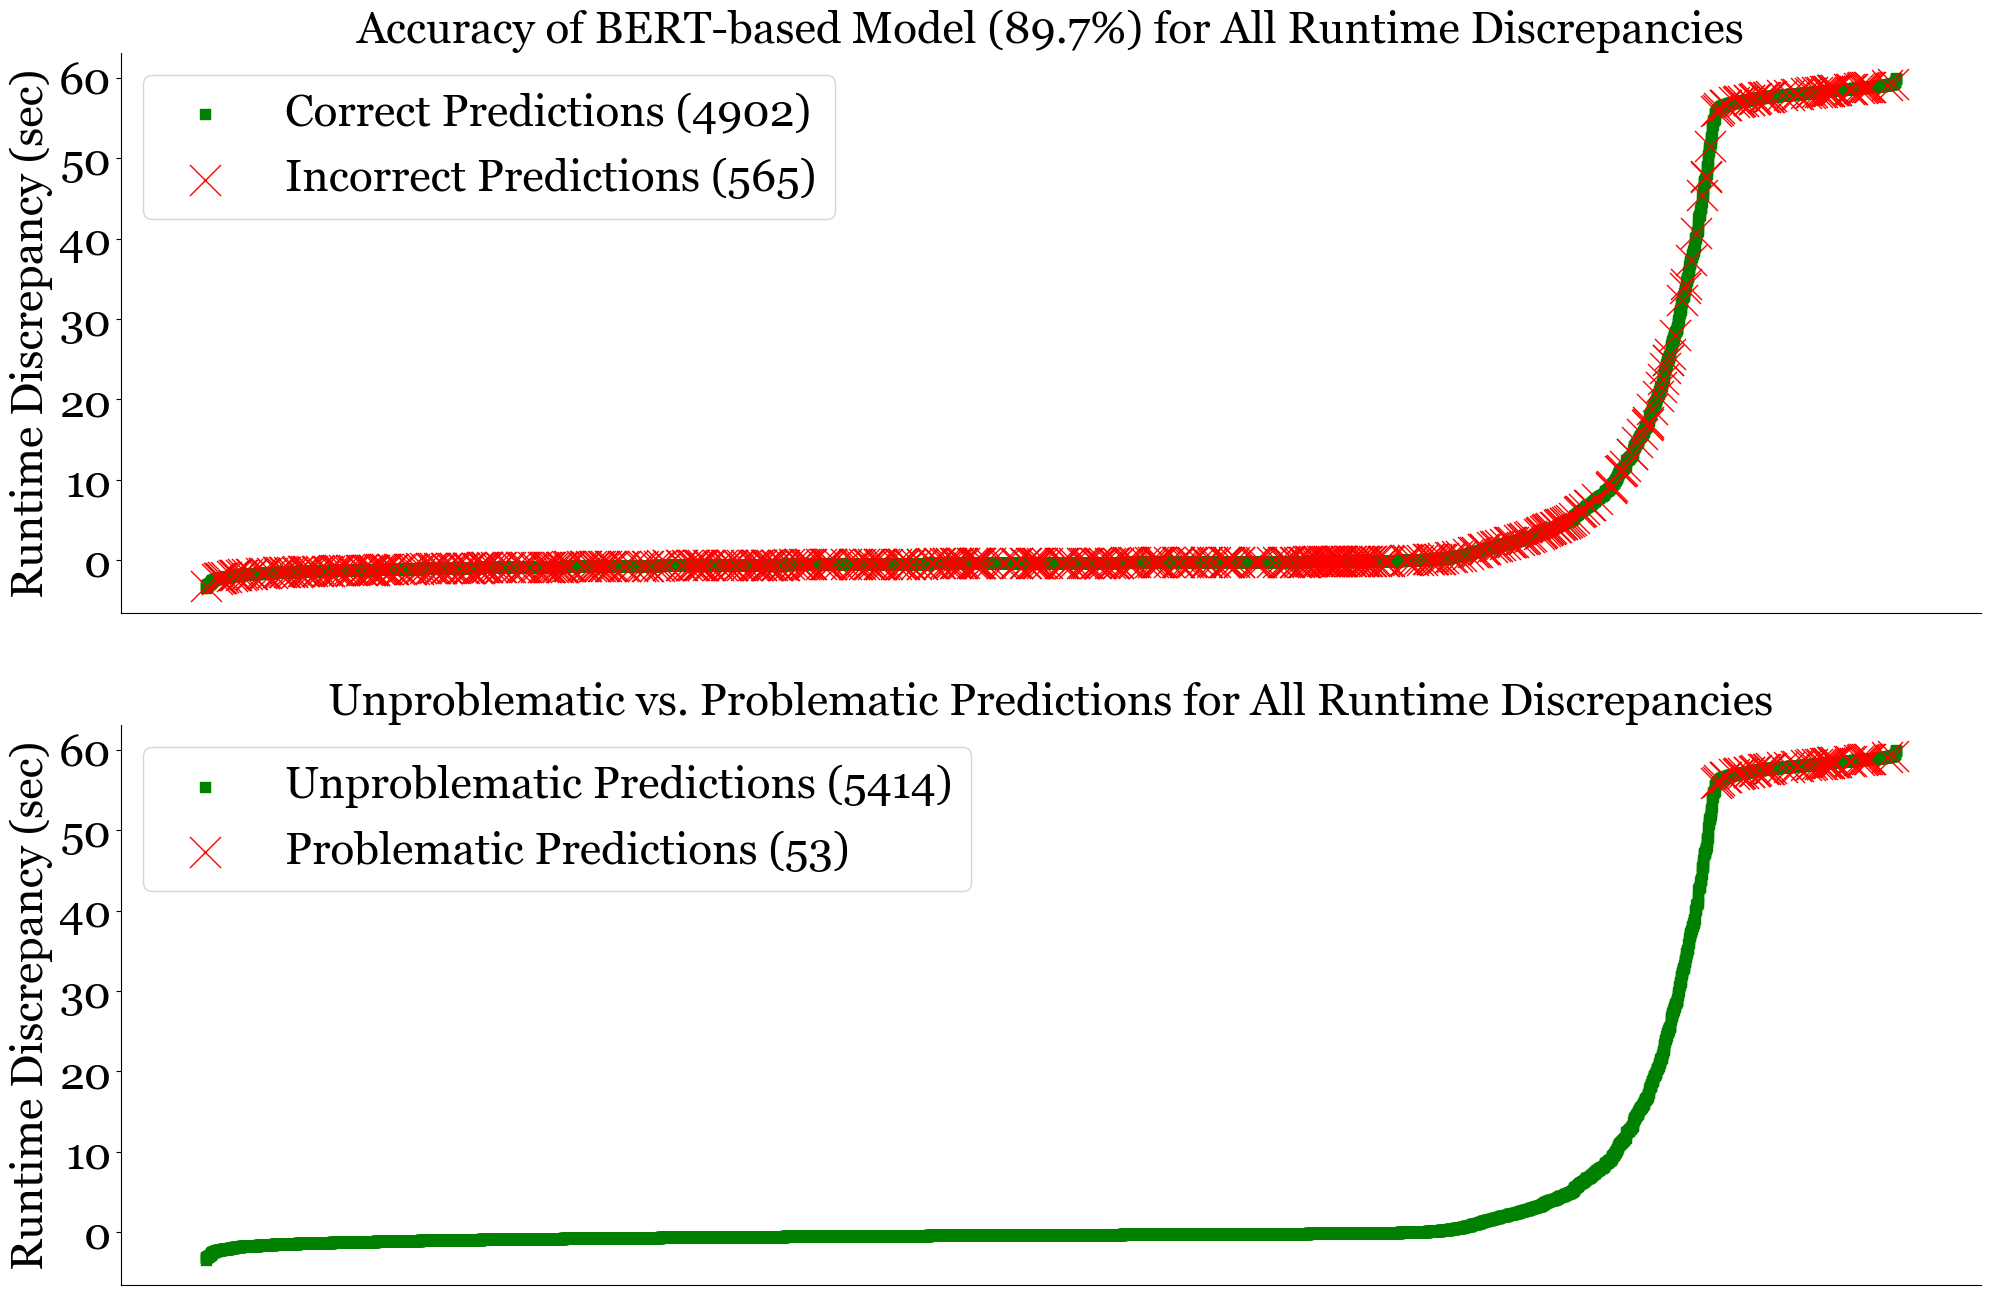

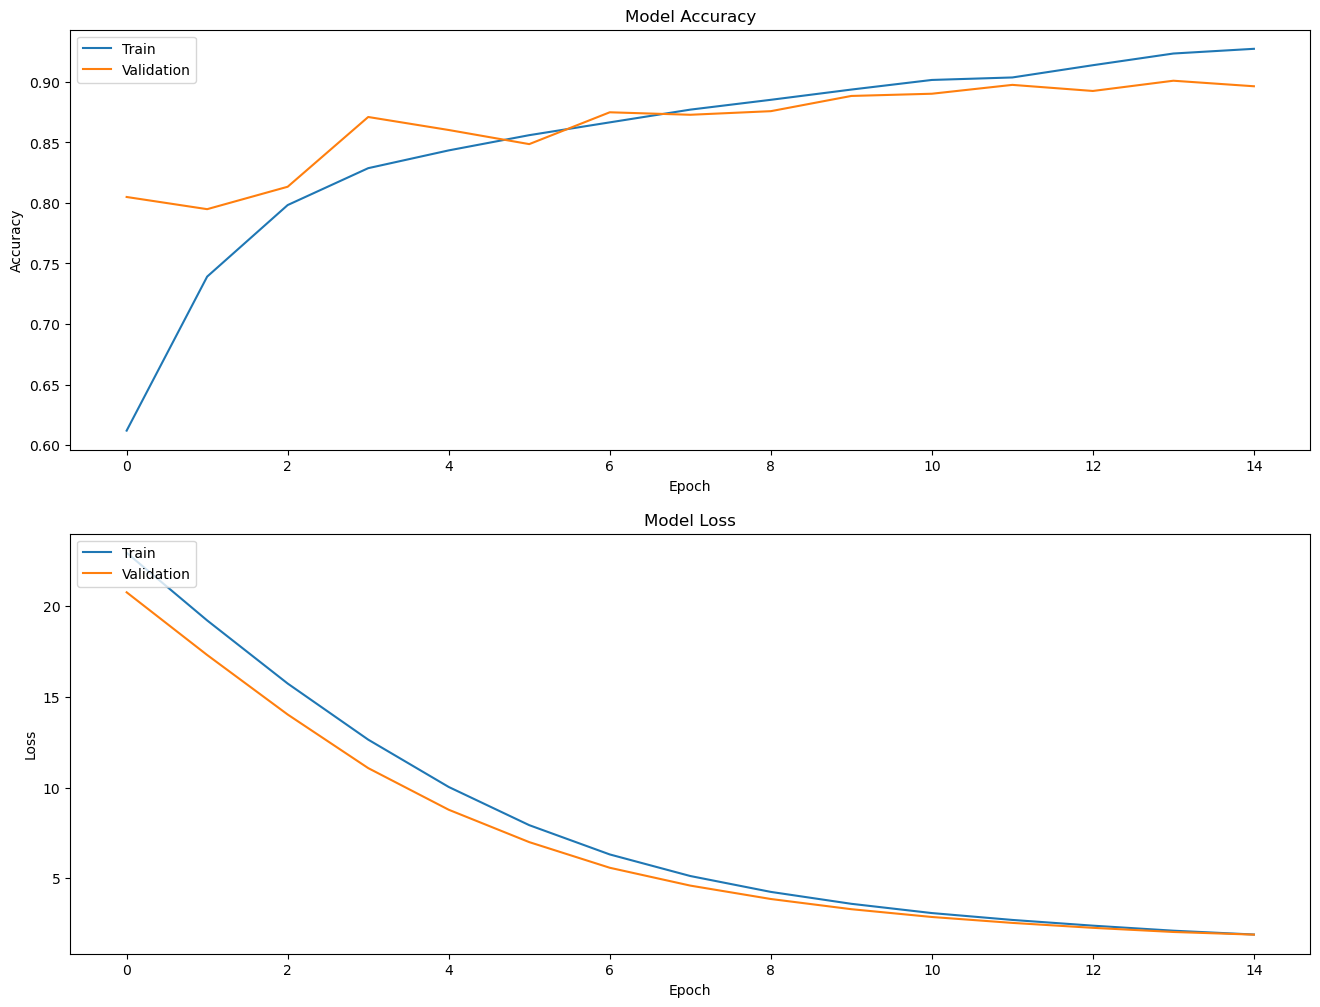

171/171 [==============================] - 10s 46ms/step


C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True  True  True ...  True  True  True]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_test.loc[df_test.index.isin(y_test.index), "Correct_Prediction"] = \
C:\Users\wrick\AppData\Local\Temp\ipykernel_26544\3198662043.py:80: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, 1, 1)


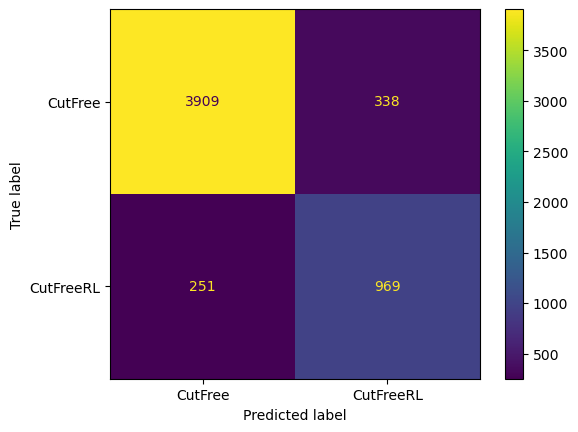

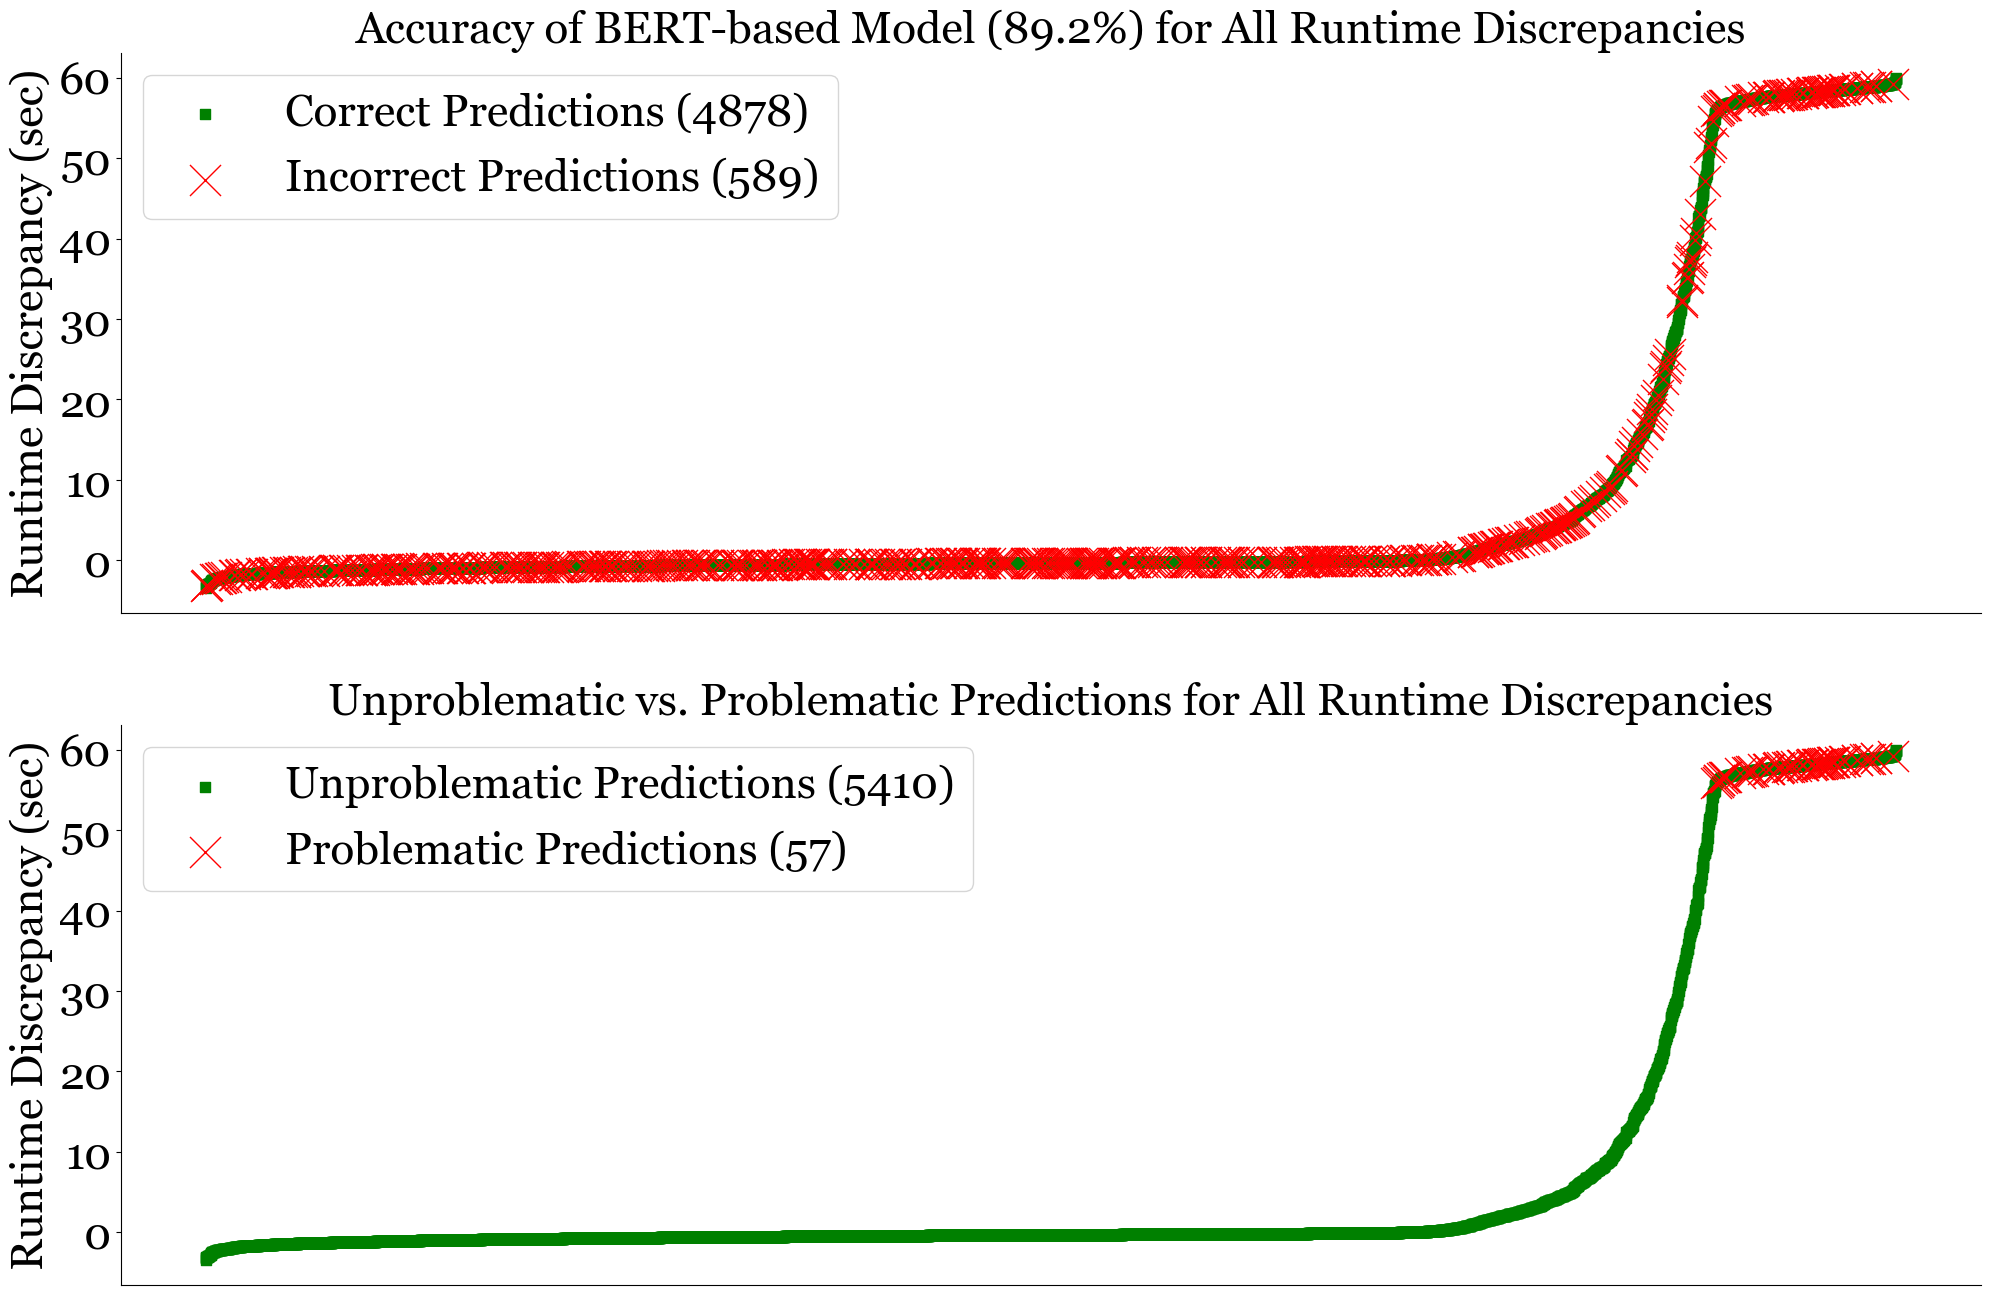

In [14]:
# kfold cross validation
kf = KFold(n_splits=KFOLDS, shuffle=True, random_state=random_state)    

# convert to arrays
x_train_array = np.array(x_train)
y_train_array = np.array(y_train)

# organize test data for analysis
x_test = np.array(x_test)

# get oligos from test inputs
x_test_oligos = ["N" * x for x in x_test_oligo_lengths]

# get sites from test inputs
x_test_sites = []
for x in x_test:
    temp_sites = [x[i:i+10] for i in range(0, 100, 10)]
    temp_sites = [s.replace(" ", "") for s in temp_sites]
    temp_sites = list(filter(None, temp_sites))
    x_test_sites.append(temp_sites)
    
# make tensor for test data that contains the oligo length
bert_test_ints = tf.convert_to_tensor(
    (x_test_oligo_lengths)
)

# tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(BERT_MODEL_NAME)

# tokenize test data
tokens_test = tokenizer.batch_encode_plus(
    x_test, 
    padding="max_length",
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

# get input ids and attention masks for test data
input_ids_test = tokens_test["input_ids"]
attention_mask_test = tokens_test["attention_mask"]

# make tensors for bert test data
texts_test = (
    input_ids_test, 
    attention_mask_test, 
    bert_test_ints
)
labels_test = tf.constant(y_test)
bert_test_dataset = tf.data.Dataset.from_tensor_slices(
    (texts_test, labels_test)
).shuffle(len(labels_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for k, (train_index, val_index) in enumerate(
    kf.split(x_train_array, y_train_array)
):
    # instantiate new model
    model = build_bert()

    # create optimizer and loss function
    optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    # compile model
    model.compile(optimizer, loss, metrics=["accuracy"])

    # get train and validation data
    x_train_cv = x_train_array[train_index]
    x_val_cv = x_train_array[val_index]
    y_train_cv = y_train_array[train_index]
    y_val_cv = y_train_array[val_index]

    # make tensor for train data that contains the oligo length
    bert_train_ints = tf.convert_to_tensor(
        (x_train_oligo_lengths)
    )

    # class weights (if not balanced)
    class_weights = dict(
        enumerate(
            compute_class_weight(
                class_weight="balanced", 
                classes=np.unique(y_train_cv), 
                y=np.array(y_train_cv)
            )
        )
    )

    # save class weights
    with open(
        save_folder + f"/results/k{str(k)}_class_weights.csv", "w"
    ) as f:
        for key in class_weights.keys():
            f.write("%s,%s\n"%(key, class_weights[key]))

    # callbacks for early stopping, saving checkpoints, and tensorboard
    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            patience=3,
            monitor="val_loss"
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=save_folder \
                + "/checkpoints/k" + str(k) + "_best_model_acc.h5",
            monitor="val_accuracy", 
            save_best_only=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath=save_folder \
                + "/checkpoints/k" + str(k) + "_best_model_loss.h5",
            monitor="val_loss", 
            save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=save_folder + "/logs" + "/k" + str(k),
        )
    ]
    
    # tokenize training data
    tokens_train = tokenizer.batch_encode_plus(
        x_train_cv, 
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="tf"
    )

    # get input ids and attention masks for training data
    input_ids_train = tokens_train["input_ids"]
    attention_mask_train = tokens_train["attention_mask"]

    # make tensors for training data
    texts_train = (
        input_ids_train, 
        attention_mask_train, 
        np.array(bert_train_ints)[train_index]
    )
    labels_train = tf.constant(y_train_cv)
    bert_train_dataset = tf.data.Dataset.from_tensor_slices(
        (texts_train, labels_train)
    ).shuffle(len(labels_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # tokenize validation data
    tokens_val = tokenizer.batch_encode_plus(
        x_val_cv, 
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="tf"
    )

    # get input ids and attention masks for validation data
    input_ids_val = tokens_val["input_ids"]
    attention_mask_val = tokens_val["attention_mask"]

    # make tensors for validation data
    texts_val = (
        input_ids_val, 
        attention_mask_val, 
        np.array(bert_train_ints)[val_index]
    )
    labels_val = tf.constant(y_val_cv)
    bert_val_dataset = tf.data.Dataset.from_tensor_slices(
        (texts_val, labels_val)
    ).shuffle(len(labels_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    # fine-tune model to training data
    bert_history = model.fit(
            bert_train_dataset,
            validation_data=bert_val_dataset, 
            epochs=EPOCHS, 
            batch_size=BATCH_SIZE,
            class_weight=class_weights,
            callbacks=model_callbacks
    )

    # plot training and validation accuracy
    plot_train_val(bert_history, k)

    # evaluate model
    evaluate_model(
        tokenizer, 
        model, 
        bert_test_dataset, 
        texts_test, 
        x_test_oligos, 
        x_test_sites,
        k
    )

In [15]:
# load tensorboard
%tensorboard --logdir logs

UsageError: Line magic function `%tensorboard` not found.


# Train Non BERT-based MLP and Obtain Results

In [16]:
# build an mlp to classify the algorithm based on the oligo length, number of
# sites, and site length as a comparison metric for the bert model
def build_mlp():
    # oligo length, number of sites, and site length
    mlp_inputs = tf.keras.Input(
        shape=(3,),
        name="mlp_inputs",
        dtype="float32"
    )

    # 2 layer mlp
    mlp = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(
                128, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_1_mlp"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_1_mlp"),
            tf.keras.layers.Dropout(0.4, name="dropout_1_mlp"),
            tf.keras.layers.Activation("relu", name="relu_1_mlp"),
            tf.keras.layers.Dense(
                64, 
                kernel_regularizer = tf.keras.regularizers.L1(1e-3),
                bias_regularizer = tf.keras.regularizers.L1(1e-3),
                activity_regularizer = tf.keras.regularizers.L1(1e-3),
                name="dense_2_mlp"
            ),
            tf.keras.layers.BatchNormalization(name="batch_norm_2_mlp"),
            tf.keras.layers.Dropout(0.4, name="dropout_2_mlp"),
            tf.keras.layers.Activation("relu", name="relu_2_mlp")
        ], 
        name="mlp"
    )(mlp_inputs)

    # softmax output layer
    mlp_outputs = tf.keras.layers.Dense(
        1,
        activation="sigmoid",
        name="mlp_outputs"
    )(mlp)
    
    # instantiate model
    mlp_model = tf.keras.Model(
        inputs=mlp_inputs,
        outputs=mlp_outputs,
        name="MLP_AlgorithmClassifier"
    )

    return mlp_model

In [17]:
# make tensors for train and validation data that contain the oligo length, 
# number of sites, and site length
x_train_array_mlp = np.array(
    (x_train_oligo_lengths, x_train_number_of_sites, x_train_site_lengths)
).T
y_train_array_mlp = np.array(y_train)

# kfold cross validation
kf = KFold(n_splits=MLP_KFOLDS, shuffle=True, random_state=random_state) 

# mlp losses and accuracies
mlp_losses = []
mlp_accs = []

for k, (train_index, val_index) in enumerate(
    kf.split(x_train_array_mlp, y_train_array_mlp)
):
    # instantiate new model
    mlp_model = build_mlp()

    # create optimizer and loss function
    optimizer = AdamWeightDecay(learning_rate=5e-5, weight_decay_rate=0.01)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

    # compile model
    mlp_model.compile(optimizer, loss, metrics=["accuracy"])

    # get train and validation data
    x_train_mlp_cv = x_train_array_mlp[train_index]
    x_val_mlp_cv = x_train_array_mlp[val_index]
    y_train_mlp_cv = tf.constant(y_train_array_mlp[train_index])
    y_val_mlp_cv = tf.constant(y_train_array_mlp[val_index])

    # class weights (if not balanced)
    class_weights = dict(
        enumerate(
            compute_class_weight(
                class_weight="balanced", 
                classes=np.unique(y_train_mlp_cv), 
                y=np.array(y_train_mlp_cv)
            )
        )
    )

    # callbacks for early stopping, saving checkpoints, and tensorboard
    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3)
    ]

    # make tensors for training and validation datasets
    mlp_train_dataset = tf.data.Dataset.from_tensor_slices(
        (x_train_mlp_cv, y_train_mlp_cv)
    ).shuffle(len(train_index)).batch(MLP_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    mlp_val_dataset = tf.data.Dataset.from_tensor_slices(
        (x_val_mlp_cv, y_val_mlp_cv)
    ).shuffle(len(val_index)).batch(MLP_BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # fit model to training data
    history_mlp = mlp_model.fit(
        mlp_train_dataset,
        validation_data=mlp_val_dataset, 
        epochs=MLP_EPOCHS, 
        batch_size=MLP_BATCH_SIZE,
        class_weight=class_weights,
        callbacks=model_callbacks
    )

    # make tensors for test labels
    labels_test = tf.constant(y_test)

    # make tensors for mlp test data
    tf_test_mlp = tf.transpose(
        tf.convert_to_tensor(
            (x_test_oligo_lengths, x_test_number_of_sites, x_test_site_lengths)
        )
    )
    mlp_test_dataset = tf.data.Dataset.from_tensor_slices(
        (tf_test_mlp, labels_test)
    ).shuffle(len(labels_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # get accuracy and loss of model
    loss, acc = mlp_model.evaluate(mlp_test_dataset)
    mlp_losses.append(loss)
    mlp_accs.append(acc)

Epoch 1/15
274/274 [==============================] - 3s 7ms/step - loss: 2.2155 - accuracy: 0.2857 - val_loss: 2.1594 - val_accuracy: 0.4794
Epoch 2/15
274/274 [==============================] - 2s 7ms/step - loss: 1.9280 - accuracy: 0.4046 - val_loss: 1.8477 - val_accuracy: 0.6232
Epoch 3/15
274/274 [==============================] - 2s 7ms/step - loss: 1.7490 - accuracy: 0.5003 - val_loss: 1.6521 - val_accuracy: 0.7236
Epoch 4/15
274/274 [==============================] - 2s 7ms/step - loss: 1.6129 - accuracy: 0.5662 - val_loss: 1.5171 - val_accuracy: 0.7490
Epoch 5/15
274/274 [==============================] - 2s 7ms/step - loss: 1.4956 - accuracy: 0.6209 - val_loss: 1.3992 - val_accuracy: 0.7666
Epoch 6/15
274/274 [==============================] - 2s 7ms/step - loss: 1.4031 - accuracy: 0.6572 - val_loss: 1.3123 - val_accuracy: 0.7711
Epoch 7/15
274/274 [==============================] - 2s 7ms/step - loss: 1.3204 - accuracy: 0.6832 - val_loss: 1.2324 - val_accuracy: 0.7780
Epoch 

## Evaluate Model Performance of BERT vs. MLP

In [27]:
# load bert accuracies
bert_accs = []
for k in range(KFOLDS):
    with open(
        save_folder + "/results/k" + str(k) + "_accuracy_results.csv", "r"
    ) as f:
        reader = csv.reader(f)
        for row in reader:
            bert_accs.append(float(row[0].split("(")[1].split(",")[0]))
            break
            
# get average accuracy of bert-based models
bert_accs = np.array(bert_accs)
bert_acc = np.mean(bert_accs)
bert_std = np.std(bert_accs)
print("BERT Accuracy: ", bert_acc, " +/- ", bert_std)

# get average accuracy of mlp-based models
mlp_accs = np.array(mlp_accs) * 100
mlp_acc = np.mean(mlp_accs)
mlp_std = np.std(mlp_accs)
print("MLP Accuracy: ", mlp_acc, " +/- ", mlp_std)

BERT Accuracy:  88.71044300000001  +/-  1.221482176684701
MLP Accuracy:  75.4746675491333  +/-  1.3477991188798046


# Load Model and Make New Predictions

In [30]:
# import dependencies
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel, AdamWeightDecay

# load model
best_model = tf.keras.models.load_model(
    save_folder + "/checkpoints/k4_best_model_loss.h5",
    custom_objects={
        "TFDistilBertModel": TFDistilBertModel, 
        "AdamWeightDecay": AdamWeightDecay
    }
)

# load tokenizer
new_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

In [37]:
# get input
text_1 = "AGCT GGATC GGCC AAGCT CTGCAG GCGGCCGC"
text_2 = "CNNR GGATC GGCC AAGCT CTGCAG GCGGCCGC"
text_attributes = tf.transpose(
    tf.convert_to_tensor(
        ([15, 40, 15, 40])
    )
)

new_tokens_test = new_tokenizer.batch_encode_plus(
    [text_1, text_1, text_2, text_2], 
    padding='max_length',
    max_length=MAX_LENGTH,
    return_tensors="tf"
)

new_input_ids_test = new_tokens_test["input_ids"]
new_attention_mask_test = new_tokens_test["attention_mask"]

new_texts_test = (new_input_ids_test, new_attention_mask_test, text_attributes)

# predict
new_y_pred = np.round(best_model.predict(new_texts_test)).reshape(1, -1)

print(
    "Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL): ", new_y_pred
)

1/1 [==============================] - 0s 65ms/step
Reconstructed Model Prediction (0 = CutFree, 1 = CutFreeRL):  [[0. 1. 0. 0.]]


### Note: 
Above demonstrates that the model has learned that "CNNR" is a recognition site that is often incompatible with CutFreeRL. We see that at sequence lengths of 15, each input is sent to CutFree; however, at a sequence length of 40, the non-CNNR input goes to CutFreeRL, where as the CNNR input still goes to CutFree. This is one example of our model performing well with an edge case.